In [1]:
import sys
sys.path.append('/Users/gregmartinez/.local/share/virtualenvs/mtg_scraper-N8QFuhGA/lib/python3.8/site-packages/')

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test, ttest_1samp, chi2_contingency, ttest_ind, f_oneway
from matplotlib.backends.backend_pdf import PdfPages
import re
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

In [4]:
FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv")
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv")
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

event_table["date"] = pd.to_datetime(event_table["date"])
full_table["date"] = pd.to_datetime(full_table["date"])
deck_table["rank"] = pd.to_numeric(deck_table["rank"])

In [5]:
deck_table.tail(25)

deckId  eventId  pilotId                 deckUrl  \
3263    3264      623      688  ?e=29293&d=430447&f=ST   
3264    3265      623     1017  ?e=29293&d=430449&f=ST   
3265    3266      623     1942  ?e=29293&d=430448&f=ST   
3266    3267      623     1864  ?e=29293&d=430451&f=ST   
3267    3268      623     1943  ?e=29293&d=430453&f=ST   
3268    3269      623      399  ?e=29293&d=430450&f=ST   
3269    3270      623     1944  ?e=29293&d=430452&f=ST   
3270    3271      624      198  ?e=29295&d=430470&f=ST   
3271    3272      624     1945  ?e=29295&d=430471&f=ST   
3272    3273      625     1946  ?e=29290&d=430412&f=ST   
3273    3274      625     1947  ?e=29290&d=430413&f=ST   
3274    3275      626     1948  ?e=29291&d=430414&f=ST   
3275    3276      626      453  ?e=29291&d=430415&f=ST   
3276    3277      626     1031  ?e=29291&d=430417&f=ST   
3277    3278      626     1844  ?e=29291&d=430416&f=ST   
3278    3279      626      355  ?e=29291&d=430420&f=ST   
3279    3280      626      609  ?e=29291&d=430418&f=ST   
3280    3281      626     1781  ?e=29291&d=430421&f=ST   
3281    3282      626     1586  ?e=29291&d=430419&f=ST   
3282    3283      627     1727  ?e=29300&d=430482&f=ST   
3283    3284      627       84  ?e=29300&d=430483&f=ST   
3284    3285      627     1640  ?e=29300&d=430484&f=ST   
3285    3286      627     1949  ?e=29300&d=430485&f=ST   
3286    3287      628     1950  ?e=29301&d=430486&f=ST   
3287    3288      628       90  ?e=29301&d=430487&f=ST   

                         name  rank  archetype    category  
3263             Weenie White     2      aggro  mono white  
3264    Gruul Adventure Aggro     3  adventure       gruul  
3265         Mono Green Aggro     3      aggro  mono green  
3266      Boros Cycling Aggro     5    cycling       boros  
3267  Sultai Yorion Ultimatum     5       ramp      sultai  
3268     Temur Ramp Ultimatum     5       ramp       temur  
3269             Weenie White     5      aggro  mono white  
3270      Boros Cycling Aggro     1    cycling       boros  
3271             Weenie White     2      aggro  mono white  
3272            Red Deck Wins     1      aggro    mono red  
3273             Orzhov Aggro     2      aggro      orzhov  
3274            Weenie White      1      aggro  mono white  
3275  Sultai Yorion Ultimatum     2       ramp      sultai  
3276              Gruul Aggro     3      aggro       gruul  
3277             Rakdos Aggro     3      aggro      rakdos  
3278      Boros Cycling Aggro     5    cycling       boros  
3279              Gruul Aggro     5      aggro       gruul  
3280  Sultai Yorion Ultimatum     5       ramp      sultai  
3281           Temur Midrange     5   midrange       temur  
3282             Rakdos Aggro     1      aggro      rakdos  
3283            Red Deck Wins     2      aggro    mono red  
3284               Dimir Mill     3       mill       dimir  
3285            Sultai Yorion     3    control      sultai  
3286           Grixis Control     1    control      grixis  
3287            Red Deck Wins     2      aggro    mono red

In [6]:
event_table.tail(25)

eventId                                                  name  \
603      604                             Event @ The Monkey Planet   
604      605  5K Kaldheim Championship Qualifier @ Star City Games   
605      606                   Reach Out In Love @ Insight eSports   
606      607                MAJH Sunday Series @ Malchijah Harding   
607      608                               Event @ On Curve Events   
608      609                     Weekly Event @ The Mythic Society   
609      610                  Ligue Février #3 @ Torino Tournament   
610      611                 Event @ Taverna Geek (Santos, Brasil)   
611      612                                 Event @ Lotus eSports   
612      613                    Gentry ! @ The Gentry Magic League   
613      614                               MTGO Standard Challenge   
614      615                                   Grinch Melee @ MTGA   
615      616                     Arena Tournament @ Chimera Gaming   
616      617                  KISS Tournament @ Magic for Old Guys   
617      618                               Event @ On Curve Events   
618      619      SCG Tour Online - Satellite #1 @ Star City Games   
619      620                    FNM at Home @ Draagoons Hobby Shop   
620      621                  Free Daily - Bo1 @ Owl Central Games   
621      622      SCG Tour Online - Satellite #3 @ Star City Games   
622      623      SCG Tour Online - Satellite #4 @ Star City Games   
623      624                                FNM @ Gamer's Gauntlet   
624      625                              Torneo @ War Games Arena   
625      626      SCG Tour Online - Satellite #2 @ Star City Games   
626      627                                   FNM @ Lotus eSports   
627      628                              FNM @ MTG Arena Campania   

                                           link       date latest_set  
603  https://www.mtgtop8.com/event?e=29236&f=ST 2021-02-15   Kaldheim  
604  https://www.mtgtop8.com/event?e=29235&f=ST 2021-02-14   Kaldheim  
605  https://www.mtgtop8.com/event?e=29237&f=ST 2021-02-14   Kaldheim  
606  https://www.mtgtop8.com/event?e=29238&f=ST 2021-02-14   Kaldheim  
607  https://www.mtgtop8.com/event?e=29240&f=ST 2021-02-16   Kaldheim  
608  https://www.mtgtop8.com/event?e=29241&f=ST 2021-02-16   Kaldheim  
609  https://www.mtgtop8.com/event?e=29242&f=ST 2021-02-15   Kaldheim  
610  https://www.mtgtop8.com/event?e=29252&f=ST 2021-02-16   Kaldheim  
611  https://www.mtgtop8.com/event?e=29258&f=ST 2021-02-16   Kaldheim  
612  https://www.mtgtop8.com/event?e=29265&f=ST 2021-02-16   Kaldheim  
613  https://www.mtgtop8.com/event?e=29257&f=ST 2021-02-15   Kaldheim  
614  https://www.mtgtop8.com/event?e=29266&f=ST 2021-02-17   Kaldheim  
615  https://www.mtgtop8.com/event?e=29274&f=ST 2021-02-18   Kaldheim  
616  https://www.mtgtop8.com/event?e=29273&f=ST 2021-02-17   Kaldheim  
617  https://www.mtgtop8.com/event?e=29283&f=ST 2021-02-19   Kaldheim  
618  https://www.mtgtop8.com/event?e=29288&f=ST 2021-02-19   Kaldheim  
619  https://www.mtgtop8.com/event?e=29289&f=ST 2021-02-19   Kaldheim  
620  https://www.mtgtop8.com/event?e=29284&f=ST 2021-02-17   Kaldheim  
621  https://www.mtgtop8.com/event?e=29292&f=ST 2021-02-20   Kaldheim  
622  https://www.mtgtop8.com/event?e=29293&f=ST 2021-02-20   Kaldheim  
623  https://www.mtgtop8.com/event?e=29295&f=ST 2021-02-20   Kaldheim  
624  https://www.mtgtop8.com/event?e=29290&f=ST 2021-02-19   Kaldheim  
625  https://www.mtgtop8.com/event?e=29291&f=ST 2021-02-19   Kaldheim  
626  https://www.mtgtop8.com/event?e=29300&f=ST 2021-02-19   Kaldheim  
627  https://www.mtgtop8.com/event?e=29301&f=ST 2021-02-19   Kaldheim

In [7]:
LANDS = ["Island", "Mountain", "Forest", "Plains", "Swamp"]
def get_illegal_decks():
    return full_table[
        ~full_table["cardId"].isin(
            card_table[card_table["standardLegality"] == "legal"]["cardId"]
        )
    ]["deckId"]

def get_first_place_decks():
    illegal_decks = get_illegal_decks()
    return deck_table[
        (deck_table["rank"]==1)
        & (~deck_table["deckId"].isin(illegal_decks))
    ].copy()

def get_main_decks():
    illegal_decks = get_illegal_decksdecks()
    return full_table[
        (~full_table["name"].isin(LANDS))
        & (~full_table["deckId"].isin(illegal_decks))
        & (full_table["slot"] == "md")
    ].copy()

In [8]:
# Common Slices
illegal_decks = full_table[
    ~full_table["cardId"].isin(card_table[card_table["standardLegality"] == "legal"]["cardId"])
]["deckId"]

first_place_decks = deck_table[
    (deck_table["rank"] == 1)
    & ~(deck_table["deckId"].isin(illegal_decks))
].copy()
main_decks = full_table[
    (~full_table["name"].isin(["Island", "Mountain", "Forest", "Plains", "Swamp"]))
    & (full_table["slot"] == "md")
    & ~(full_table["deckId"].isin(illegal_decks))
].copy()


In [9]:
def get_most_used_cards(df):
    grouped_table = (
        df
        .copy()
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(main_decks["deckId"].nunique())
    
    return grouped_table

In [10]:
most_used_cards = get_most_used_cards(main_decks)

In [11]:
main_decks.drop_duplicates(subset=["deckId"])["name_deck"].value_counts()

Gruul Aggro                  543
Mono Green Aggro             228
Dimir Mill                   207
Red Deck Wins                177
Esper DOOM Yorion            164
Rakdos Aggro                 159
Dimir Control                110
Dimir Rogue                   87
Temur Ramp Ultimatum          80
UB Control                    62
Gruul Adventure Aggro         55
Boros Cycling Aggro           55
Selesnya Aggro                52
Izzet Control                 50
Golgari Aggro                 47
Sultai Yorion Ultimatum       46
Weenie White                  44
Naya Aggro                    43
Temur Ultimatum               41
UW Control                    34
Jund                          30
Grixis Control                27
Rakdos Control                26
UB Mill                       26
Dimir Aggro                   23
Mono Black Aggro              20
Temur Ramp Ultimatum \t       19
Boros Aggro                   17
Sultai Yorion                 17
Mono Red Control              14
Winota    

In [12]:
def most_winning_archetypes(show=False):
#     first_place_decks.loc[first_place_decks["archetype"] == "rogue", "archetype"] = "mill"
    grouped_archetypes = first_place_decks.groupby("archetype")["rank"].sum().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
#     sns.barplot(data=grouped_archetypes, x="archetype", y="rank")
    plt.bar(range(len(grouped_archetypes)), grouped_archetypes["rank"])
    plt.xticks(range(len(grouped_archetypes)), grouped_archetypes["archetype"], rotation=30)
    plt.title("Most Winning Archetypes")
    if show:
        plt.show()

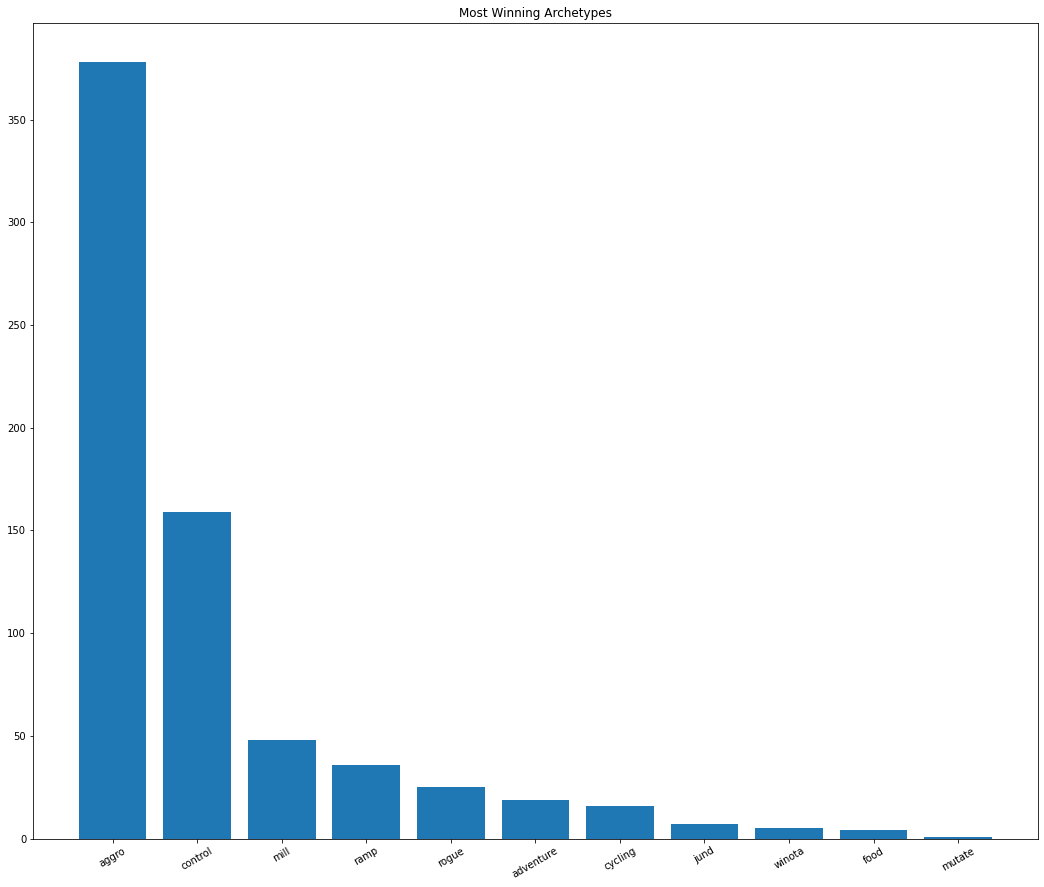

In [13]:
most_winning_archetypes()

In [14]:
def most_winning_archetypes_last_2_months(df, show=False):
    last_2_months = df[df["event_date"]]

In [15]:
def most_winning_colors(df, show=False):
    grouped_category = df.groupby("category")["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_category, x="category", y="rank")
    plt.title("Most Winning Colors")
    plt.xticks(rotation=30)
    if show:
        plt.show()

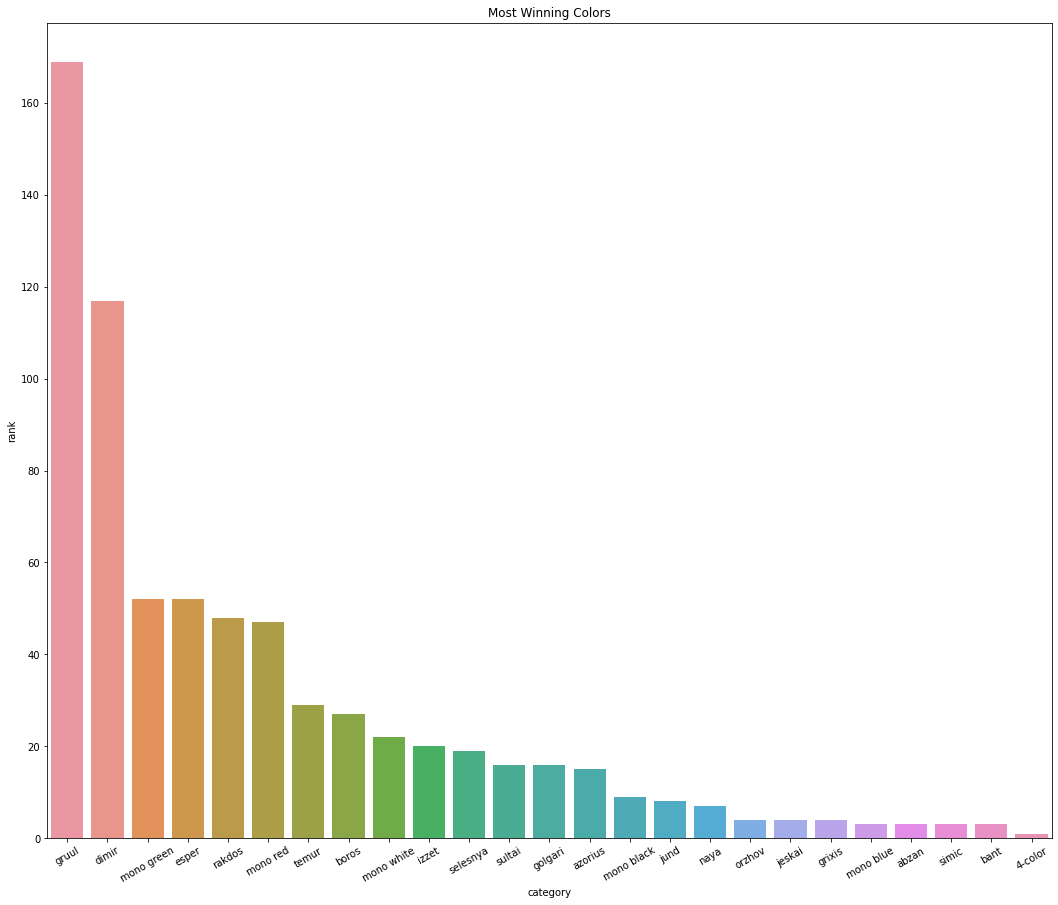

In [16]:
most_winning_colors(first_place_decks)

In [17]:
def most_winning_colors_by_set(df, show=False):
    merged_table = df.merge(event_table[["eventId", "latest_set"]], on="eventId", suffixes=[None, "_event"])
    grouped_table = merged_table.groupby(["category", "latest_set"])["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank", hue="latest_set")
    plt.title("Most Winning Colors During Each Set")
    plt.xlabel("")
    plt.ylabel("Number of Decks")
    plt.xticks(rotation=45)
    if show:
        plt.show()

# most_winning_colors_by_set(first_place_decks, show=True)

In [18]:
def what_colors_go_with_archetype(archetypes, colors):
    archetypes = deck_table[deck_table["archetype"].isin(archetypes)]["archetype"]
    colors = deck_table[deck_table["category"].isin(colors)]["category"]
    frequencies = pd.crosstab(archetypes, colors)
    chi2, pval, _, expected = chi2_contingency(frequencies)
    return chi2, pval, frequencies, expected

what_colors_go_with_archetype(["aggro"], ["mono green", "gruul"])

(0.0,
 1.0,
 category   gruul  mono green
 archetype                   
 aggro        556         260,
 array([[556., 260.]]))

In [19]:
def colors_and_archetypes(df, archetype, show=False):
    df_archetype = df[df["archetype"] == archetype].copy()
    grouped_table = (
        df_archetype
        .groupby("category")["rank"]
        .count()
        .reset_index()
        .sort_values(by="rank", ascending=False)
    )
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank")
    plt.title(f"Categories in the Most Winning {archetype.title()} Decks")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Decks")
    if show:
        plt.show()

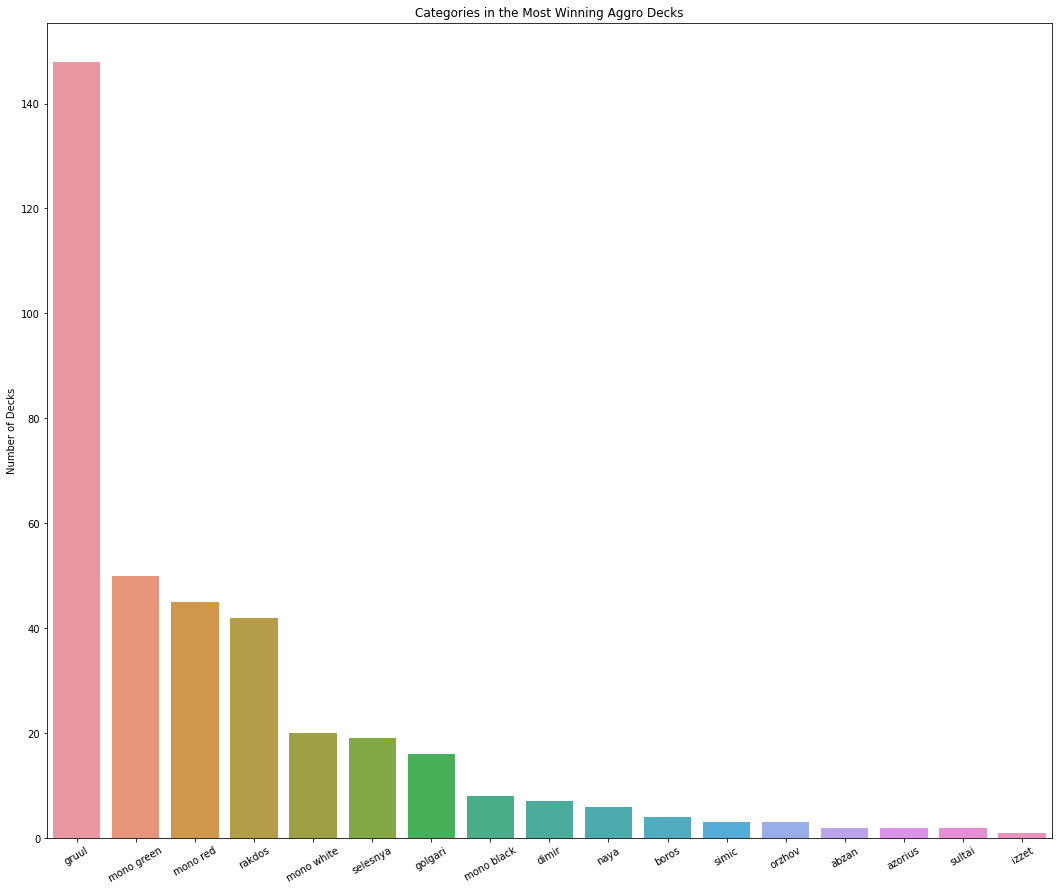

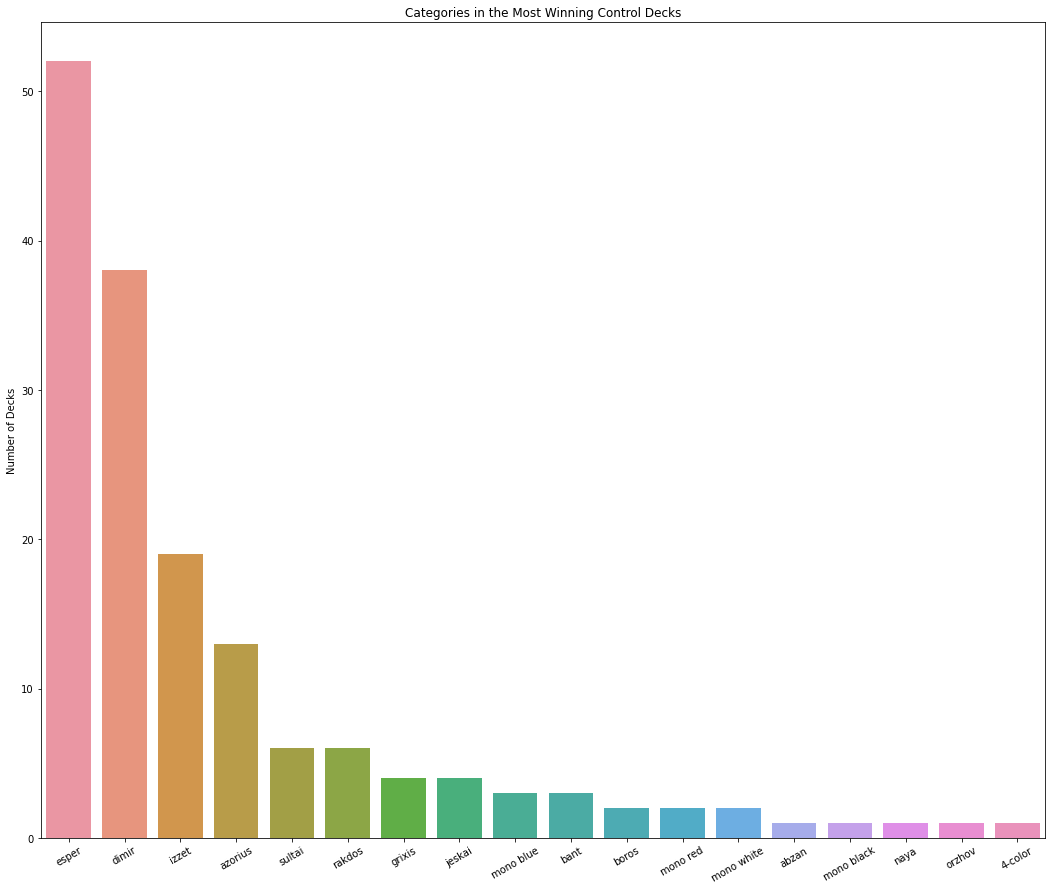

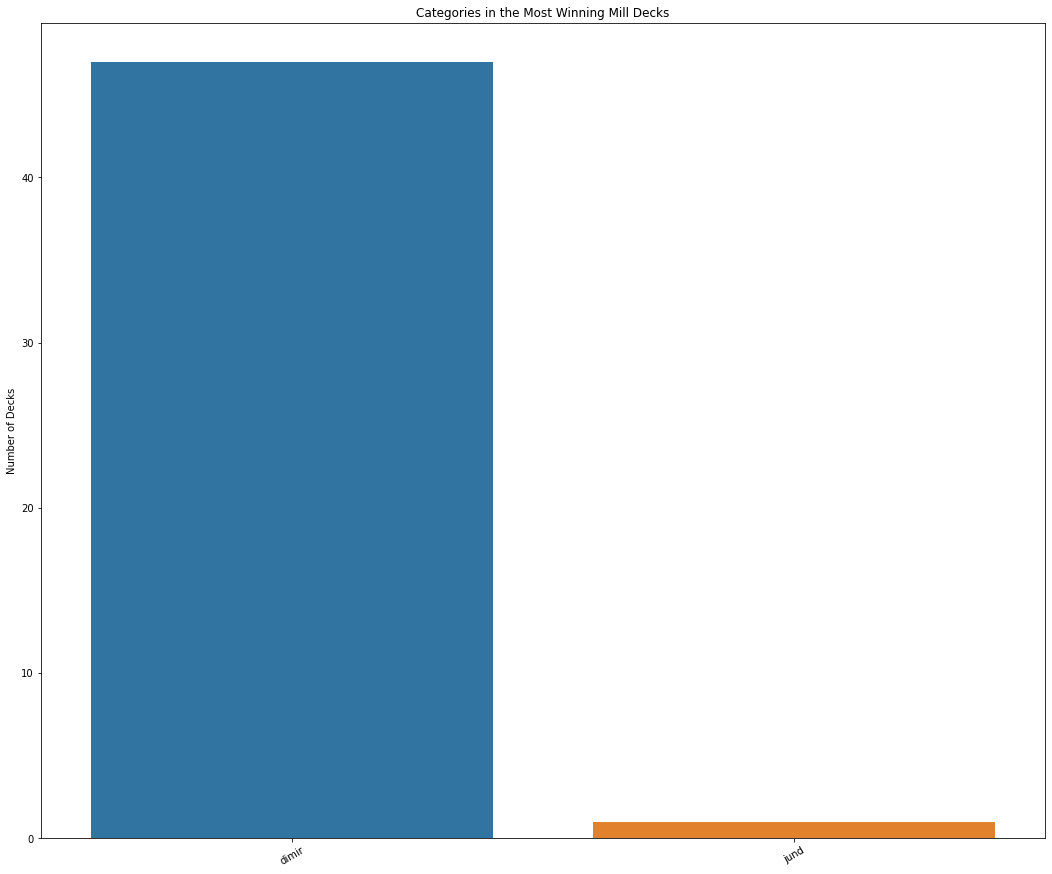

In [20]:
def topn_colors_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n].tolist()
    for archetype in topn_archetypes:
        colors_and_archetypes(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_colors_archetypes(first_place_decks, show=True, n=3)

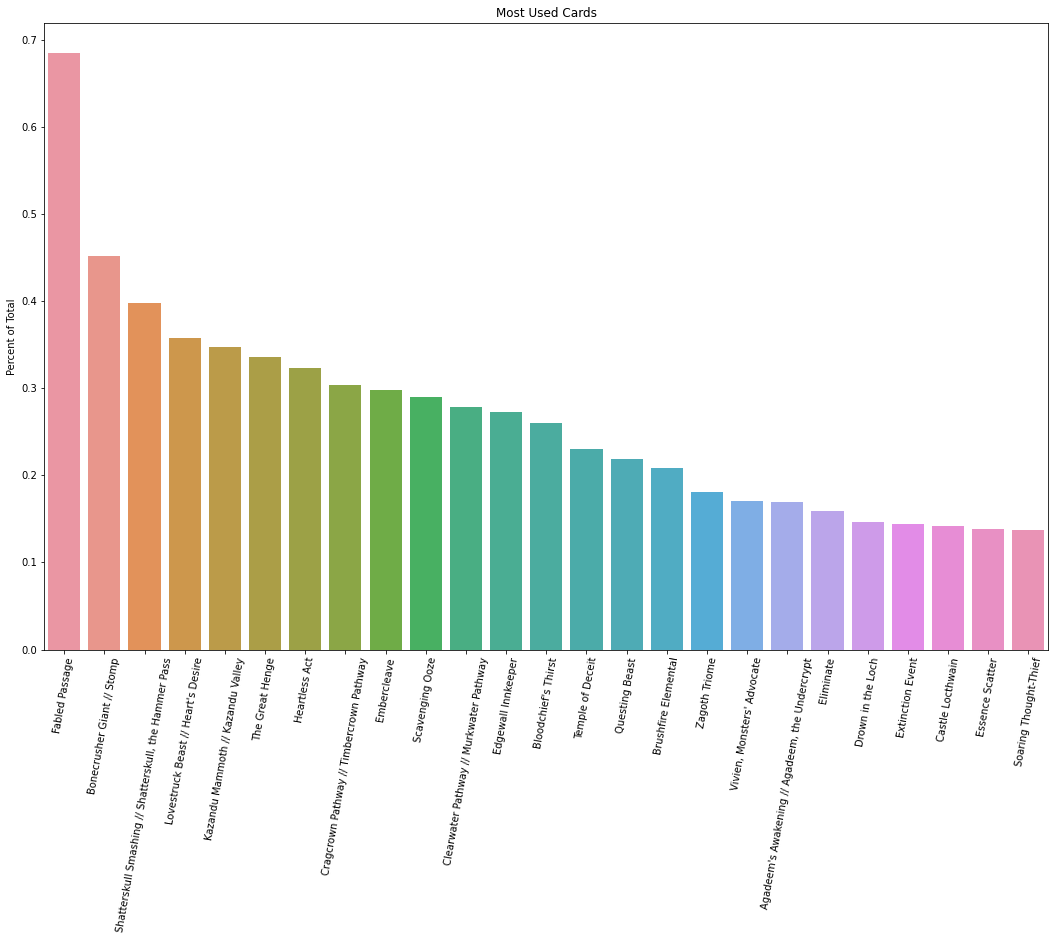

In [21]:
def most_used_cards_graphics(df, show=False):
    this_full_table = df.copy()
    grouped_table = (
        this_full_table
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(this_full_table["deckId"].nunique())
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table.iloc[:25], x="name", y="pct_total")
    plt.title("Most Used Cards")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.xlabel("")
    plt.ylabel("Percent of Total")
    if show:
        plt.show()
    
most_used_cards_graphics(main_decks, show=True)

In [22]:
def most_used_cards_in_archetype(df, archetype, show=False):
    this_df = df[df["archetype"] == archetype].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:30], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.title(f"Most Used Cards in {archetype.title()} Decks")
    plt.ylabel("Percent of All Cards")
    plt.xlabel("")
    if show:
        plt.show()

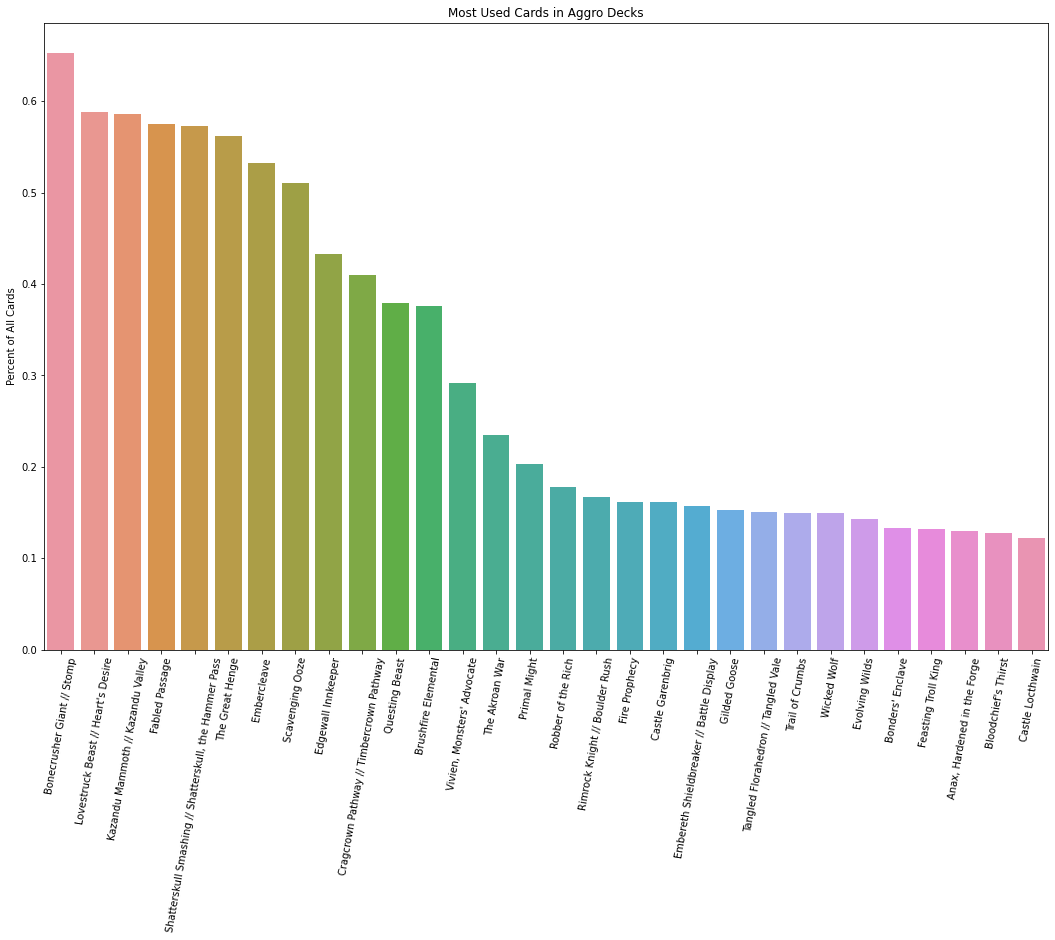

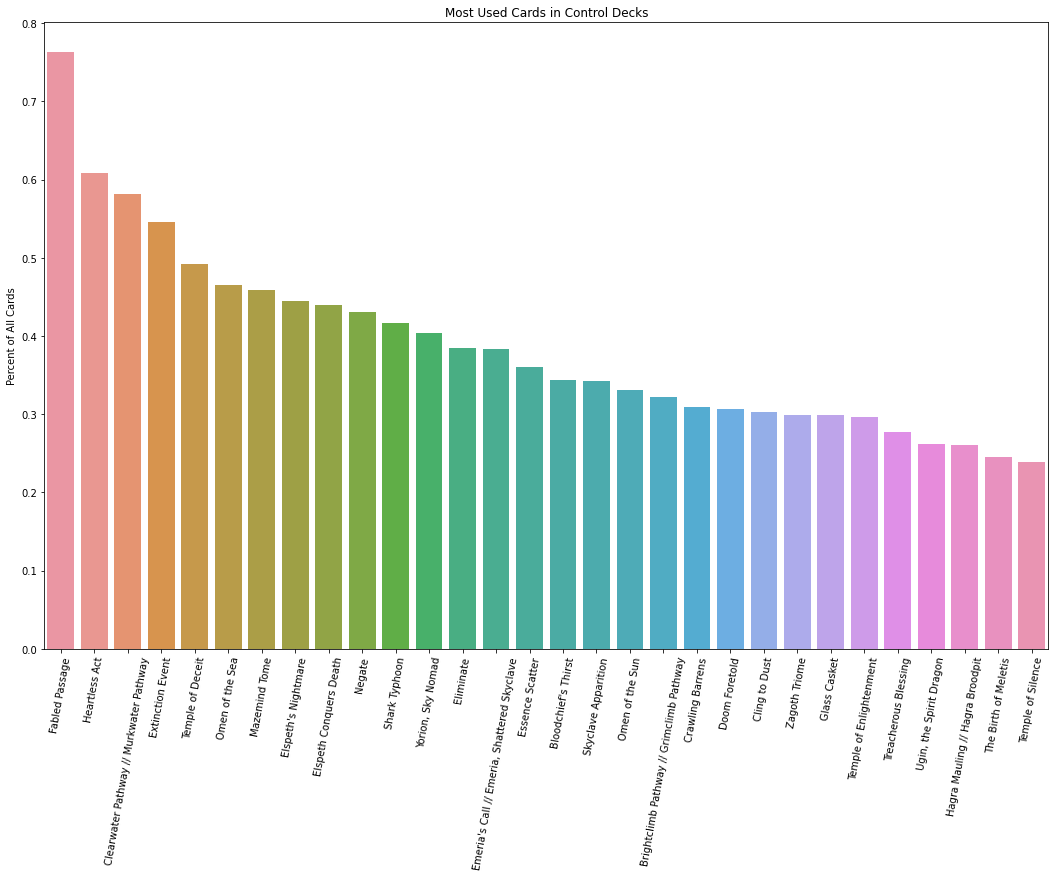

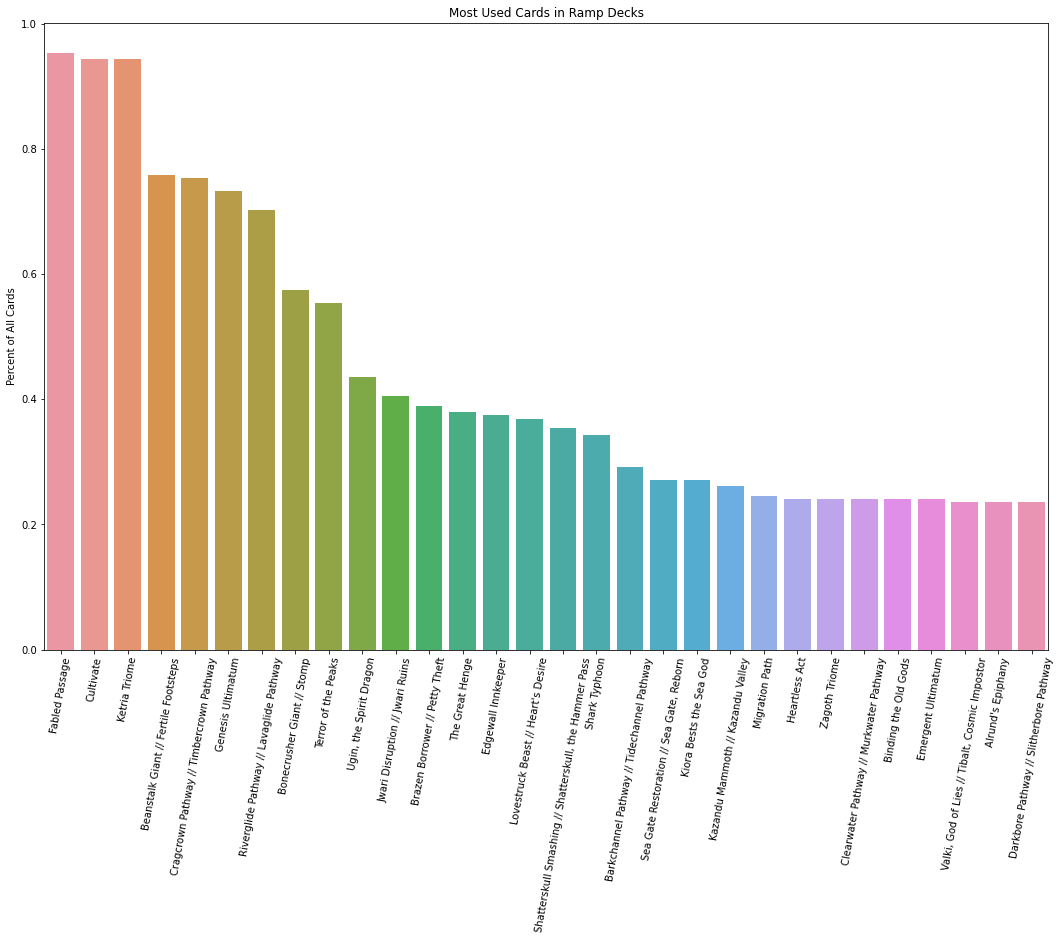

In [23]:
def topn_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = deck_table["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        most_used_cards_in_archetype(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_archetypes(main_decks, n=3, show=True)

In [24]:
def most_used_cards_in_category(df, category, show=False):
    this_df = df[df["category"] == category].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:25], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"The Top Cards for {category.title()} Decks")
    plt.ylabel("Percent of Total Decks")
    plt.xlabel("")
    plt.xticks(rotation=80)
    if show:
        plt.show()

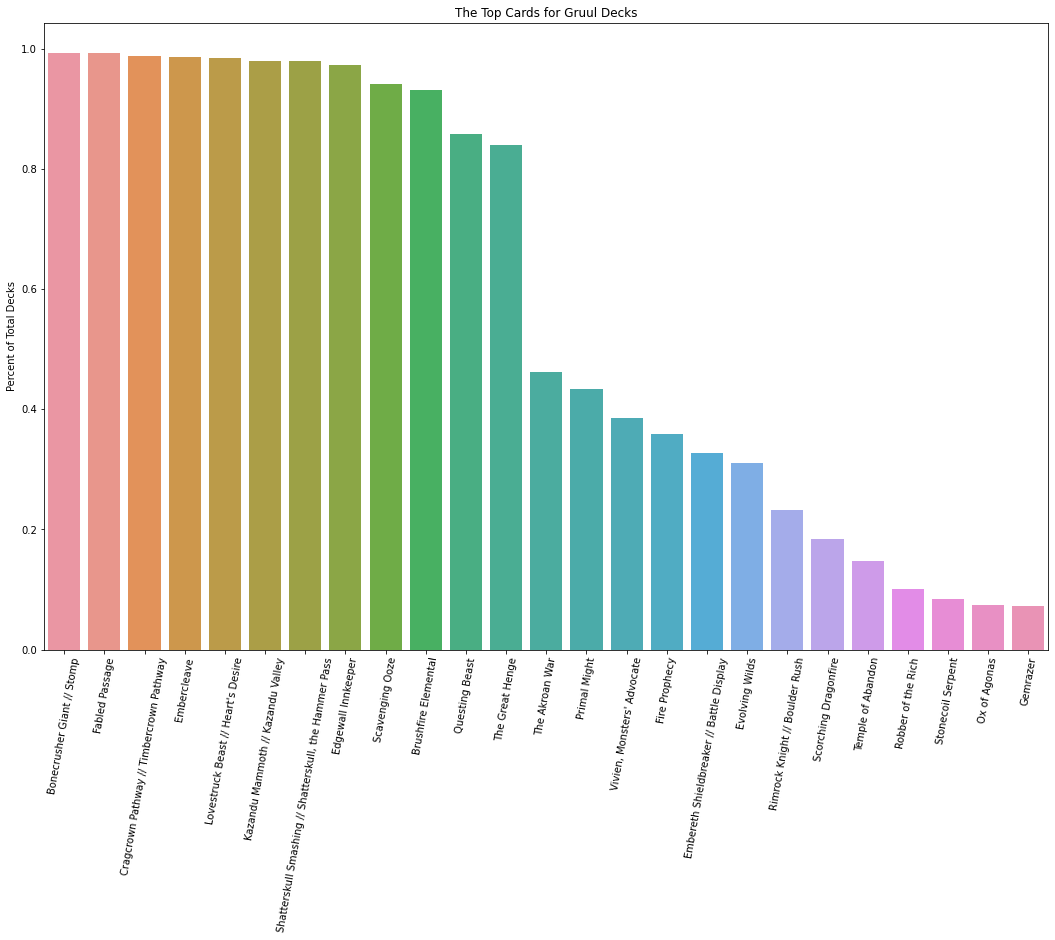

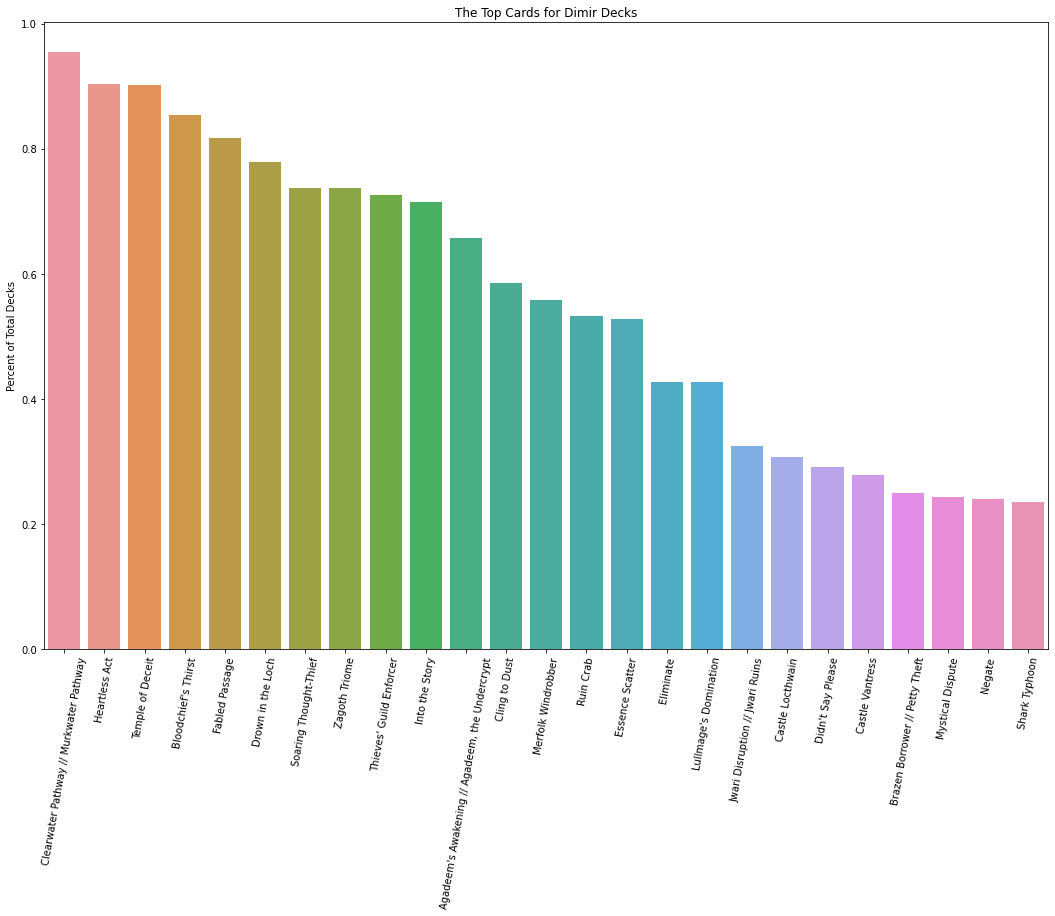

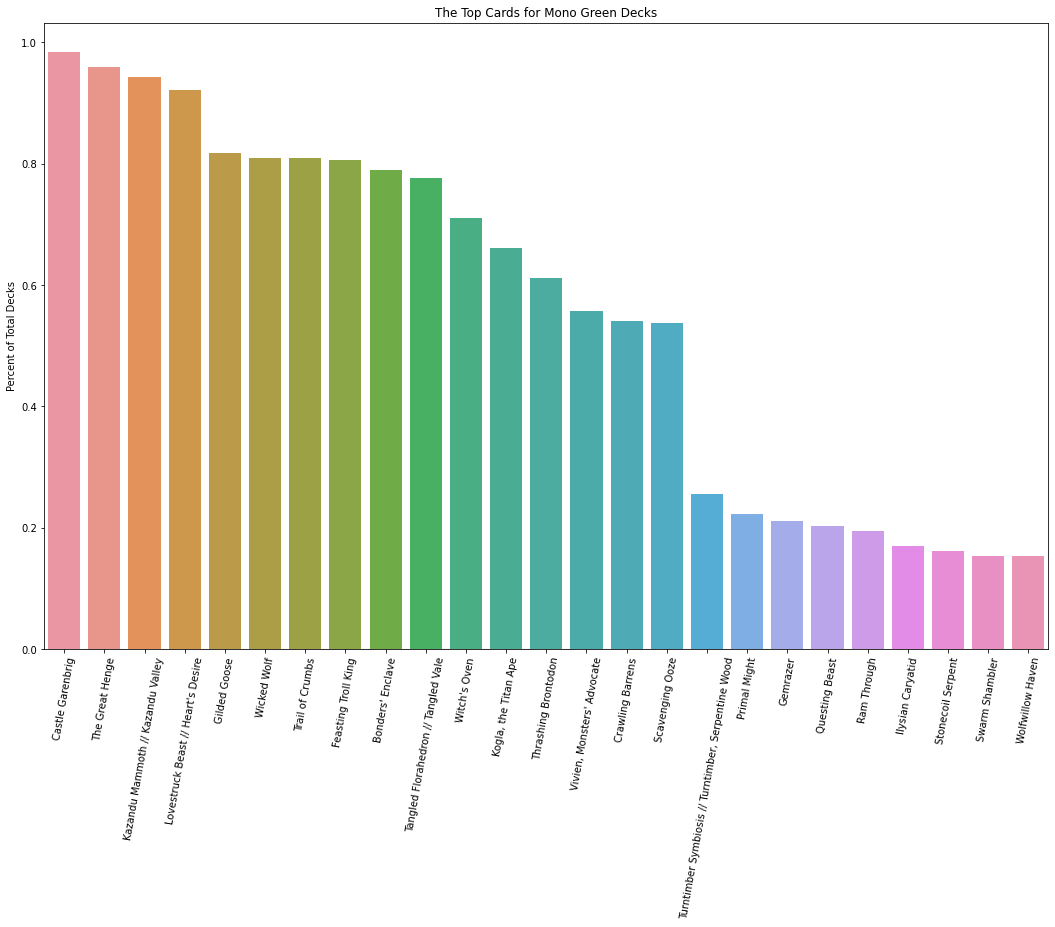

In [25]:
def topn_categories(df, n=10, show=False, pdf=None):
    topn_categories = deck_table["category"].value_counts().index[:n]
    for category in topn_categories:
        most_used_cards_in_category(df, category, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_categories(main_decks, n=3, show=True)

In [26]:
def cards_by_set(df, unique_cards=False, show=False):
    this_df = df[df["deckId"].isin(first_place_decks["deckId"])].copy()
    title = "Cards"
    if unique_cards:
        this_df.drop_duplicates(subset="name", inplace=True)
        title="Unique Cards"
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    plt.figure(figsize=(18, 15))
    sns.countplot(x=this_df["set"], order=this_df["set"].value_counts().index)
    plt.title(f"{title} Used Per Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()
    

In [27]:
first_place_decks

deckId  eventId  pilotId                            deckUrl  \
0          1        1        3             ?e=27938&d=421597&f=ST   
2          3        2        5             ?e=27939&d=421599&f=ST   
3          4        3        6             ?e=27940&d=421600&f=ST   
4          5        4        7             ?e=27925&d=421512&f=ST   
12        13        5       15             ?e=27918&d=421478&f=ST   
16        17        6       19             ?e=27921&d=421484&f=ST   
24        25        7       26             ?e=27886&d=421193&f=ST   
26        27        8       28             ?e=27898&d=421353&f=ST   
30        31        9       32             ?e=27901&d=421373&f=ST   
38        39       10       39             ?e=27902&d=421381&f=ST   
42        43       11       43             ?e=27919&d=421482&f=ST   
43        44       12       44             ?e=27920&d=421483&f=ST   
44        45       13       45             ?e=27941&d=421601&f=ST   
46        47       14       47             ?e=27876&d=421119&f=ST   
54        55       15       54             ?e=27885&d=421189&f=ST   
58        59       16       57             ?e=27888&d=421199&f=ST   
66        67       17       65             ?e=27905&d=421389&f=ST   
74        75       18       73             ?e=27860&d=421013&f=ST   
82        83       19       81             ?e=27863&d=421032&f=ST   
85        86       20       84             ?e=27877&d=421127&f=ST   
93        94       21       91             ?e=27878&d=421135&f=ST   
101      102       22       99  ?e=27894&d=421299&f=ST&show_pts=Y   
121      122       23      119             ?e=27900&d=421365&f=ST   
129      130       24      127             ?e=27842&d=420939&f=ST   
137      138       25      135             ?e=27847&d=420959&f=ST   
139      140       26      137             ?e=27855&d=420991&f=ST   
141      142       27      138             ?e=27857&d=420995&f=ST   
143      144       28      140             ?e=27859&d=421005&f=ST   
151      152       29      148             ?e=27889&d=421207&f=ST   
155      156       30      152  ?e=27893&d=421249&f=ST&show_pts=Y   
156      157       30      153  ?e=27893&d=421288&f=ST&show_pts=Y   
186      187       31      183             ?e=27834&d=420857&f=ST   
194      195       32       85             ?e=27840&d=420915&f=ST   
202      203       33      198             ?e=27843&d=420947&f=ST   
204      205       34      200             ?e=27845&d=420953&f=ST   
206      207       35       18             ?e=27846&d=420955&f=ST   
210      211       36      204             ?e=27848&d=420961&f=ST   
211      212       37      205             ?e=27853&d=420981&f=ST   
219      220       38      213             ?e=27811&d=420676&f=ST   
227      228       39      221             ?e=27822&d=420766&f=ST   
235      236       40      229             ?e=27823&d=420782&f=ST   
243      244       41      237             ?e=27828&d=420820&f=ST   
244      245       42      238             ?e=27839&d=420907&f=ST   
252      253       43      245             ?e=27814&d=420710&f=ST   
254      255       44      247             ?e=27786&d=420536&f=ST   
262      263       45      254             ?e=27787&d=420544&f=ST   
270      271       46       15             ?e=27788&d=420552&f=ST   
278      279       47      268             ?e=27792&d=420580&f=ST   
280      281       48      270             ?e=27805&d=420643&f=ST   
282      283       49       40             ?e=27808&d=420660&f=ST   
286      287       50       84             ?e=27778&d=420464&f=ST   
294      295       51      280             ?e=27785&d=420520&f=ST   
302      303       52      287             ?e=27791&d=420572&f=ST   
310      311       53      295             ?e=27801&d=420633&f=ST   
312      313       54      297             ?e=27802&d=420635&f=ST   
314      315       55       18             ?e=27803&d=420637&f=ST   
318      319       56      301             ?e=27807&d=420659&f=ST   
319 

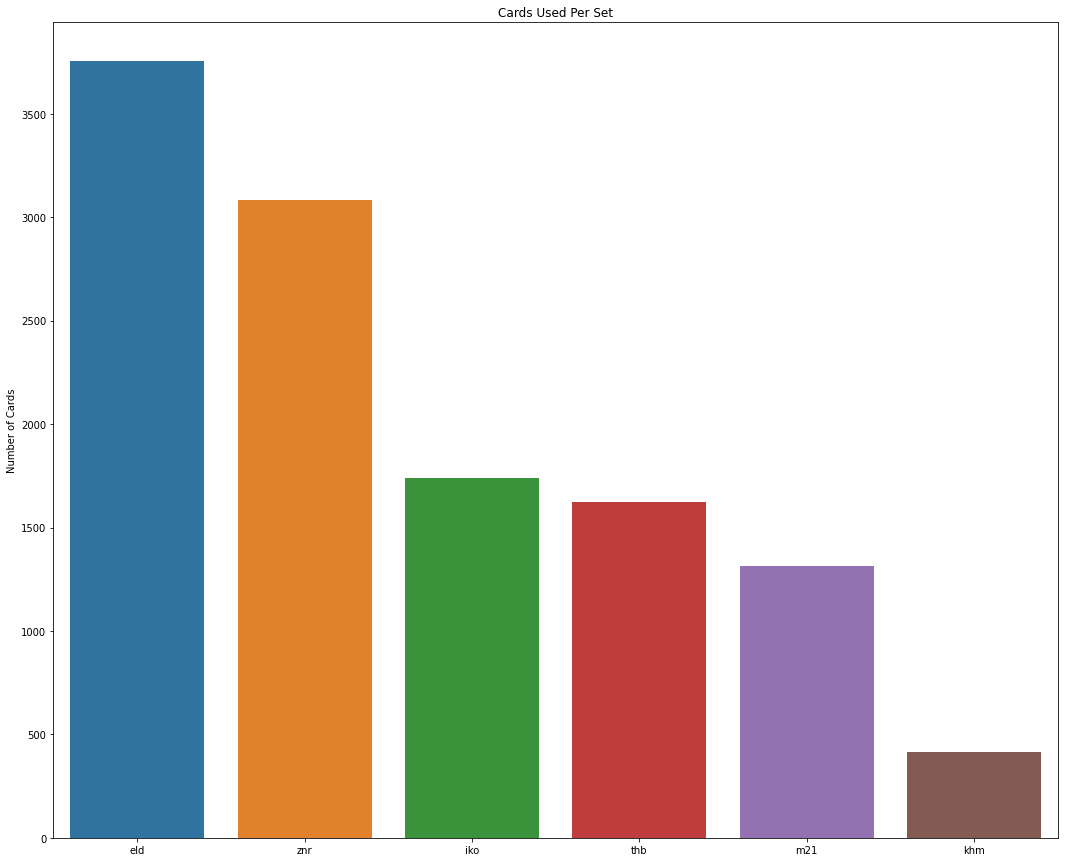

In [28]:
cards_by_set(main_decks,show=True)

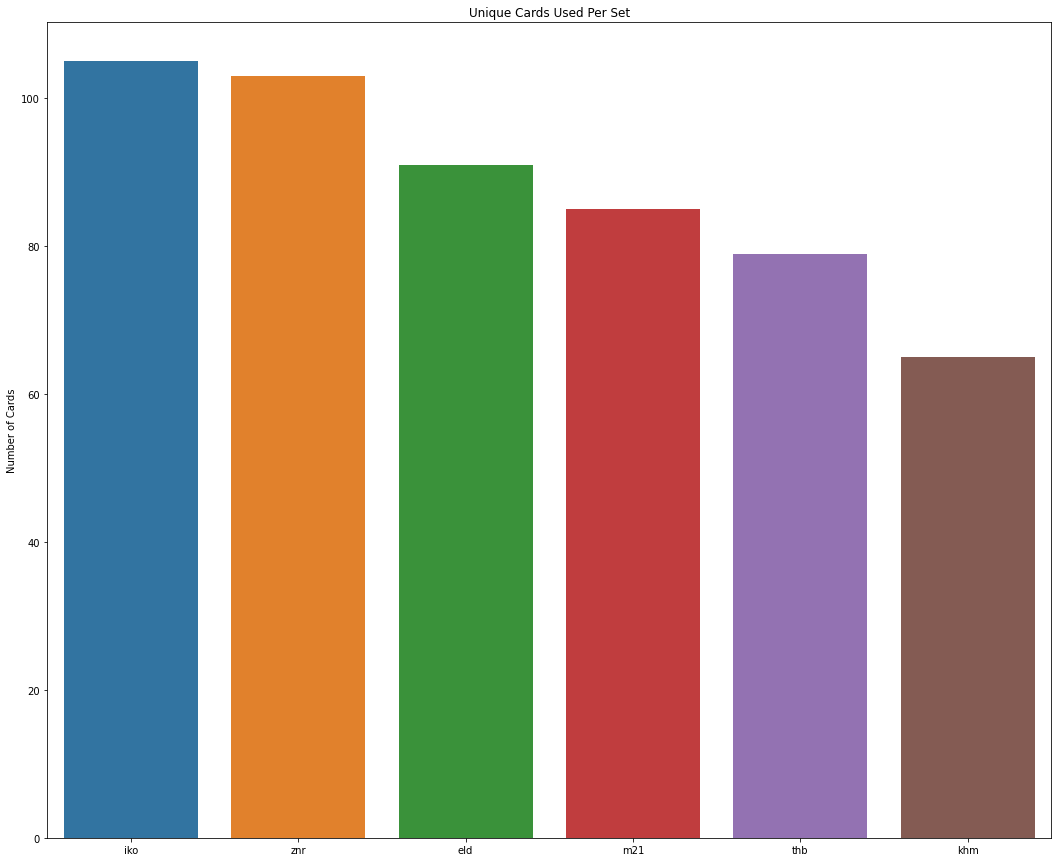

In [29]:
cards_by_set(main_decks,unique_cards=True, show=True)

In [30]:
def sort_by_date(df):
    date_order = []
    for year in ["2020", "2021"]:
        for month in [
            "January", "February", "March", "April", 
            "May", "June", "July", "August", 
            "September", "October", "November", "December"
        ]:
            date_order.append(f"{month} {year}")
    this_df = df.copy()
    
    this_df["month_year"] = pd.Categorical(
        this_df["date"].dt.month_name() + " " + (this_df["date"].dt.year).astype("str"),
        date_order,
        ordered=True
    )
    
    this_df["day"] = this_df["date"].dt.day
    
    return this_df.sort_values(by=["month_year", "day"])

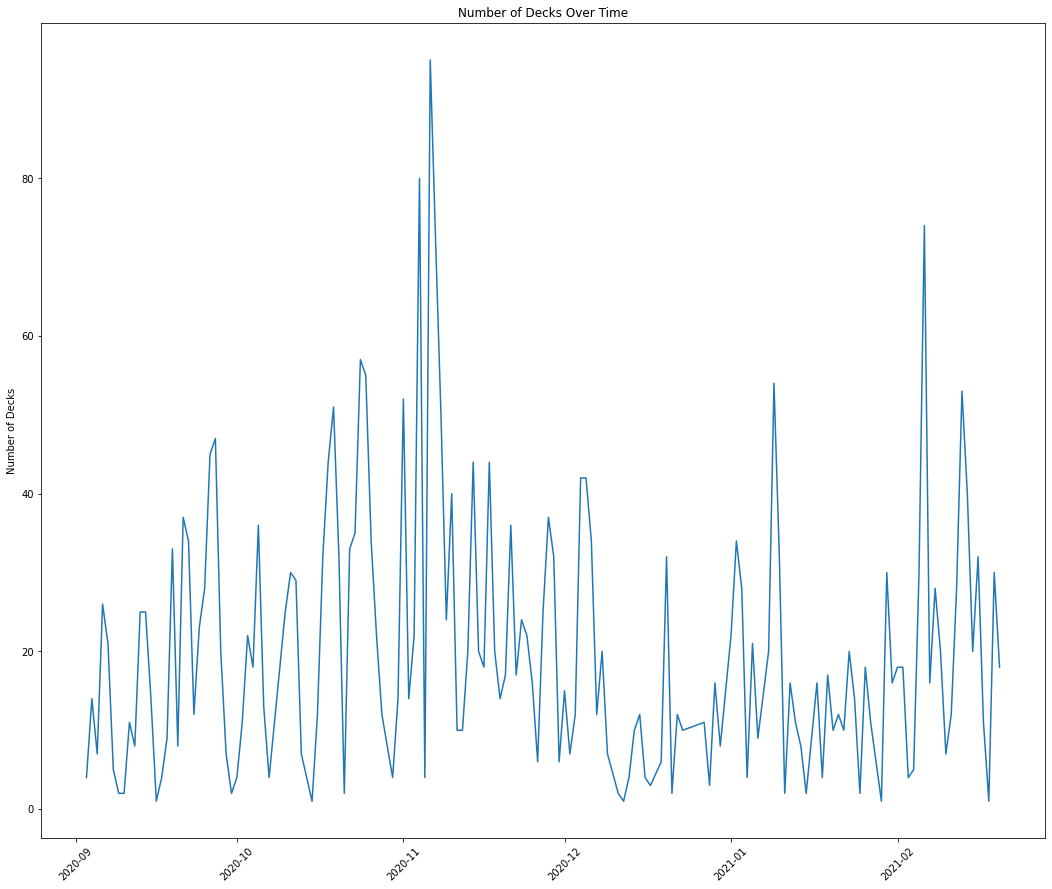

In [31]:
def number_of_decks_over_time(df, show=False):
    this_df = sort_by_date(df)
    grouped_df= (
        this_df
        .groupby(["date"])["deckId"]
        .nunique()
        .reset_index()
    )
    
    plt.figure(figsize=(18, 15))
    plt.plot(grouped_df["date"], grouped_df["deckId"])
    plt.xticks(rotation=45)
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks Over Time")
    if show:
        plt.show()
    
    
number_of_decks_over_time(full_table, show=True)

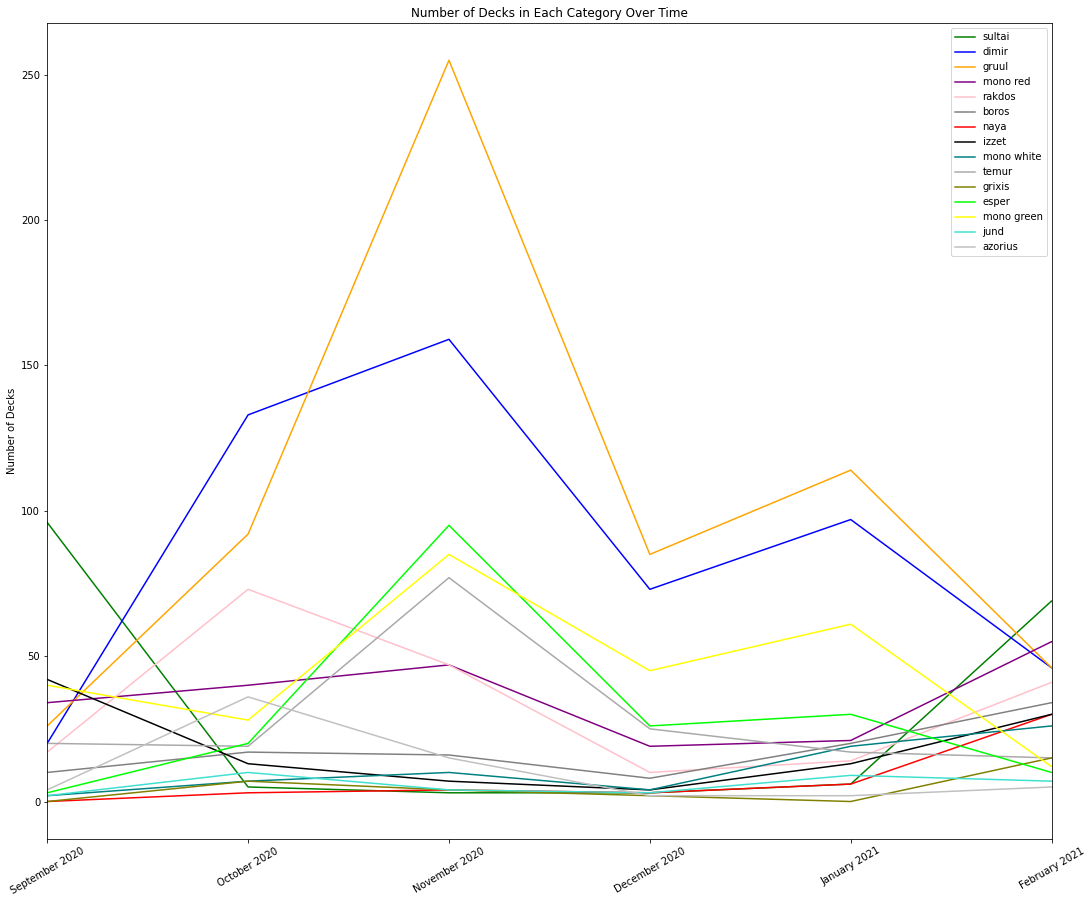

In [32]:
def categories_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "category"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_categories = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["category"].value_counts().index[:15]
    colors = ["green", "blue", "orange", "purple", "pink",
              "grey", "red", "black", "teal", "darkgrey",
              "olive", "lime", "yellow", "turquoise", "silver"
             ]
    plt.figure(figsize=(18, 15))
    for cat, color in zip(top_categories, colors):
        cat_df = grouped_df[grouped_df["category"]==cat]
        plt.plot(cat_df["month_year"], cat_df["deckId"], label=cat, color=color)
    
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks in Each Category Over Time")
    plt.legend()
    if show:
        plt.show()
    
categories_over_time(full_table, show=True)

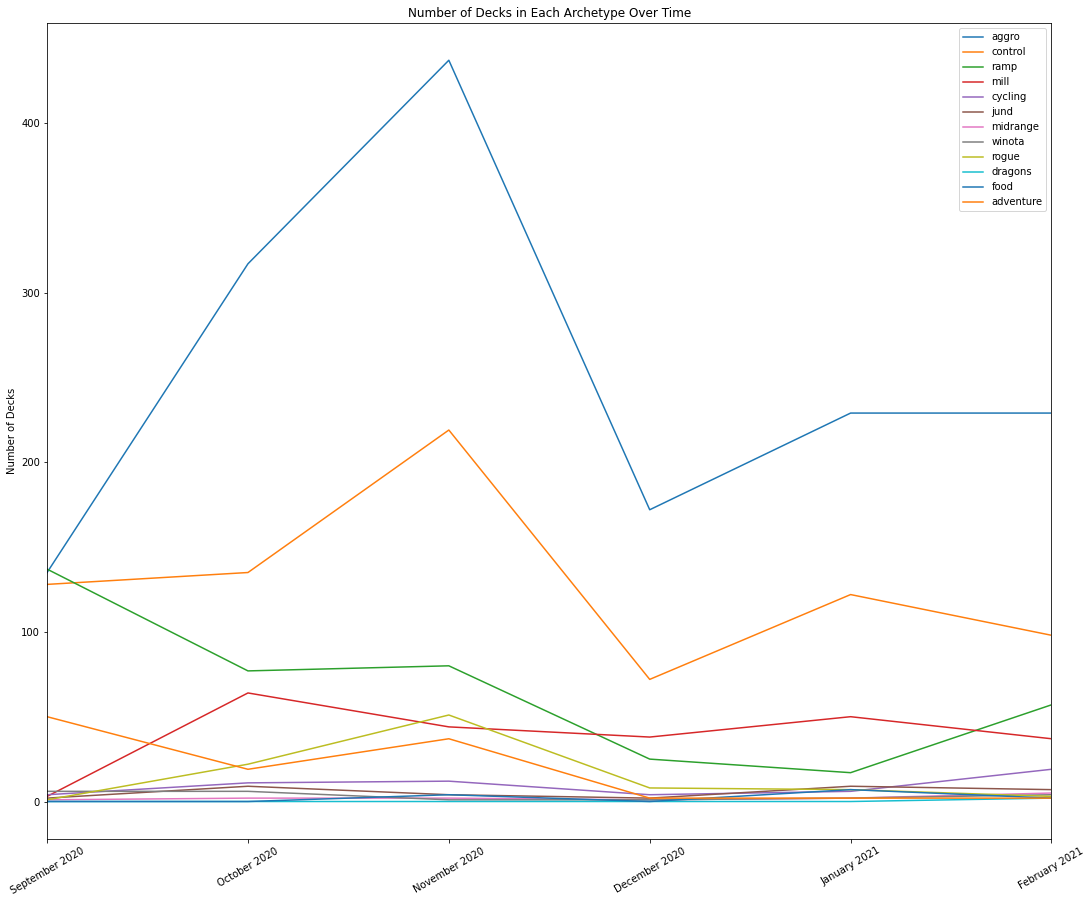

In [33]:
def archetypes_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "archetype"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_archetypes = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["archetype"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for archetype in top_archetypes:
        archetype_df = grouped_df[grouped_df["archetype"]==archetype]
        plt.plot(archetype_df["month_year"], archetype_df["deckId"], label=archetype)
    
    plt.title("Number of Decks in Each Archetype Over Time")
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.ylabel("Number of Decks")
    plt.legend()
    if show:
        plt.show()
    
archetypes_over_time(full_table, show=True)

In [34]:
def arena_vs_nonarena(df):
    this_df = df.copy()
    this_df["is_arena"] = df.apply(lambda x: "arena" if "arena" in x["name_event"].lower() else "not_arena", axis=1)
    arena_freq = pd.crosstab(this_df["archetype"], this_df["is_arena"])
    _, pval, _, _ = chi2_contingency(arena_freq)
    return pval
    

In [35]:
arena_vs_nonarena(full_table)

0.0

In [36]:
masked_table = full_table.copy()

In [37]:
cat_count = masked_table["category"].value_counts()

In [38]:
cat_count

gruul         15338
dimir         14668
mono green     6453
esper          6306
sultai         6123
4-color        6106
rakdos         5477
temur          4635
mono red       4375
izzet          3047
boros          2610
azorius        1988
golgari        1585
mono white     1498
selesnya       1405
naya           1218
jund           1030
mono black      820
grixis          805
abzan           787
orzhov          467
jeskai          447
bant            295
simic           268
mono blue       253
mardu           135
colorless        94
5-color          75
Name: category, dtype: int64

In [39]:
mask = masked_table["category"].isin(cat_count[cat_count < 2000].index)

In [40]:
mask

0        False
1        False
2        False
3        False
4        False
         ...  
88303    False
88304    False
88305    False
88306    False
88307    False
Name: category, Length: 88308, dtype: bool

In [41]:
masked_table["category"][mask] = "other"

<ipython-input-41-367f14b33268>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_table["category"][mask] = "other"


In [42]:
masked_table

eventId                name_event       date  deckId  pilotId  \
0            1  FNM @ MTG Arena Campania 2020-10-30       1        3   
1            1  FNM @ MTG Arena Campania 2020-10-30       1        3   
2            1  FNM @ MTG Arena Campania 2020-10-30       1        3   
3            1  FNM @ MTG Arena Campania 2020-10-30       1        3   
4            1  FNM @ MTG Arena Campania 2020-10-30       1        3   
...        ...                       ...        ...     ...      ...   
88303      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88304      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88305      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88306      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88307      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   

           name_deck firstName  lastName  cardId  \
0        Gruul Aggro    Antimo  Morlando  261znr   
1        Gruul Aggro    Antimo  Morlando  244eld   
2        Gruul Aggro    Antimo  Morlando  266eld   
3        Gruul Aggro    Antimo  Morlando  262eld   
4        Gruul Aggro    Antimo  Morlando  115eld   
...              ...       ...       ...     ...   
88303  Red Deck Wins    Davide     Caile  139eld   
88304  Red Deck Wins    Davide     Caile  124thb   
88305  Red Deck Wins    Davide     Caile  148thb   
88306  Red Deck Wins    Davide     Caile  156znr   
88307  Red Deck Wins    Davide     Caile  237thb   

                                           name  count color slot archetype  \
0      Cragcrown Pathway // Timbercrown Pathway      4    GR   md     aggro   
1                                Fabled Passage      4   NaN   md     aggro   
2                                        Forest      9     G   md     aggro   
3                                      Mountain      5     R   md     aggro   
4                    Bonecrusher Giant // Stomp      4     R   md     aggro   
...                                         ...    ...   ...  ...       ...   
88303                      Scorching Dragonfire      2     R   sb     aggro   
88304                            The Akroan War      3     R   sb     aggro   
88305                            Phoenix of Ash      2     R   sb     aggro   
88306                            Roiling Vortex      4     R   sb     aggro   
88307                        Soul-Guide Lantern      2   NaN   sb     aggro   

       category       latest_set  
0         gruul  Zendikar Rising  
1         gruul  Zendikar Rising  
2         gruul  Zendikar Rising  
3         gruul  Zendikar Rising  
4         gruul  Zendikar Rising  
...         ...              ...  
88303  mono red         Kaldheim  
88304  mono red         Kaldheim  
88305  mono red         Kaldheim  
88306  mono red         Kaldheim  
88307  mono red         Kaldheim  

[88308 rows x 16 columns]

In [43]:
masked_table["category"].value_counts()

gruul         15338
dimir         14668
other         13170
mono green     6453
esper          6306
sultai         6123
4-color        6106
rakdos         5477
temur          4635
mono red       4375
izzet          3047
boros          2610
Name: category, dtype: int64

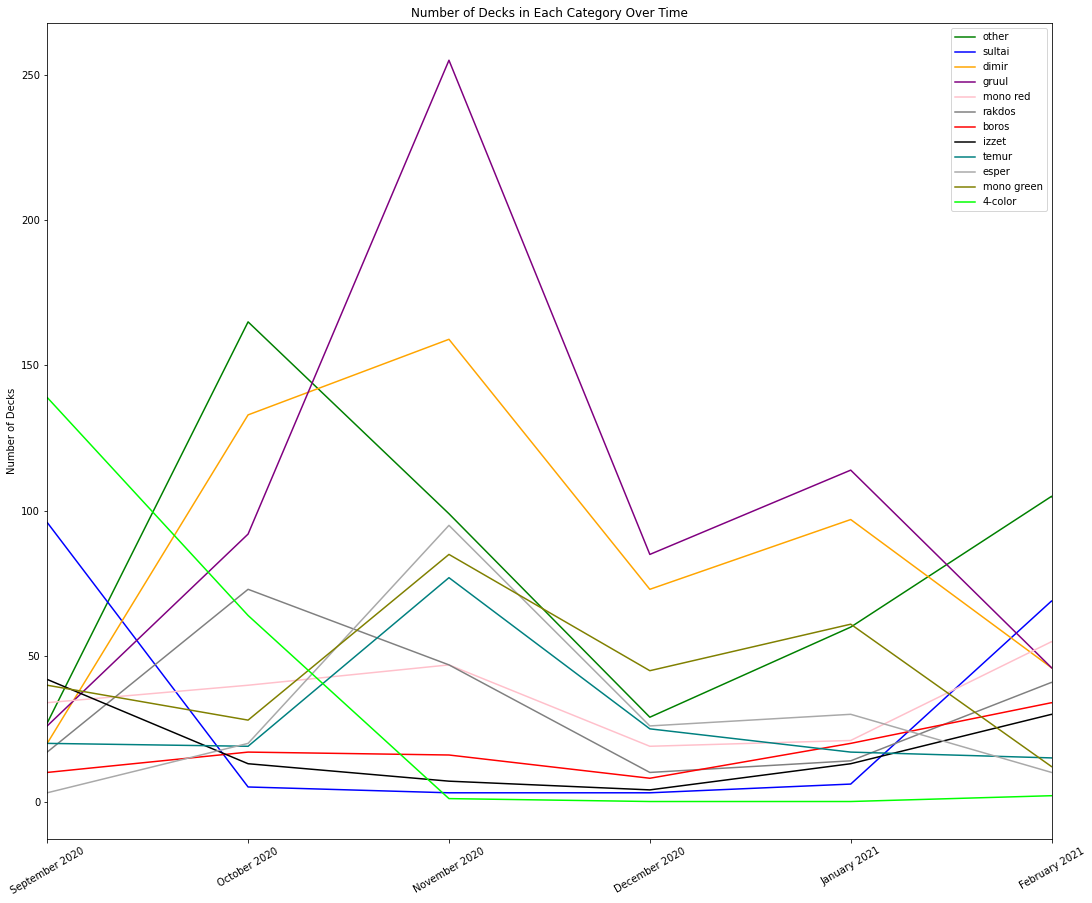

In [44]:
categories_over_time(masked_table)

In [45]:
def color_dominance(df, color, show=False):
    this_df = df.copy().fillna("")
    color_cards = this_df[
        (this_df["color"].str.contains(color))
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=color_cards, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.title(f"Most Used {color.title()} Cards")
    if show:
        plt.show()

In [46]:
def plot_color_dominance(df, show=False, pdf=None):
    for color in ["W", "U", "B", "R", "G"]:
        color_dominance(df, color, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

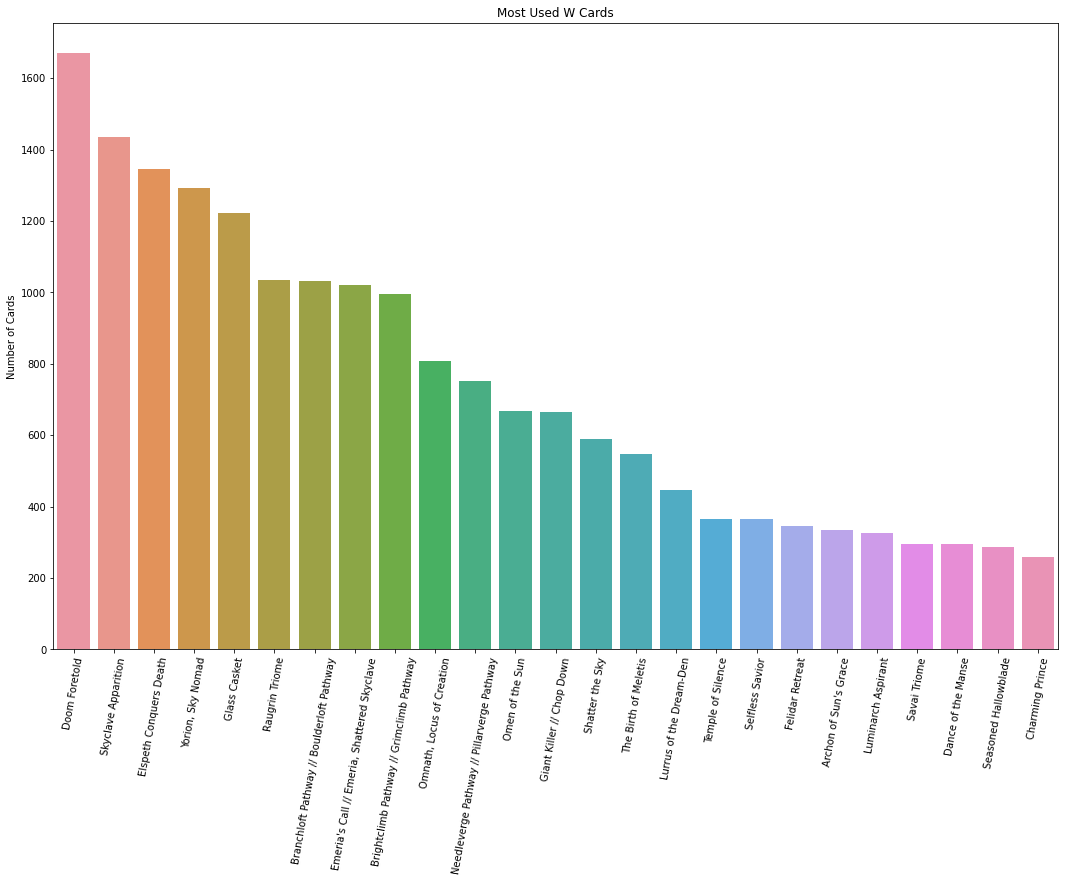

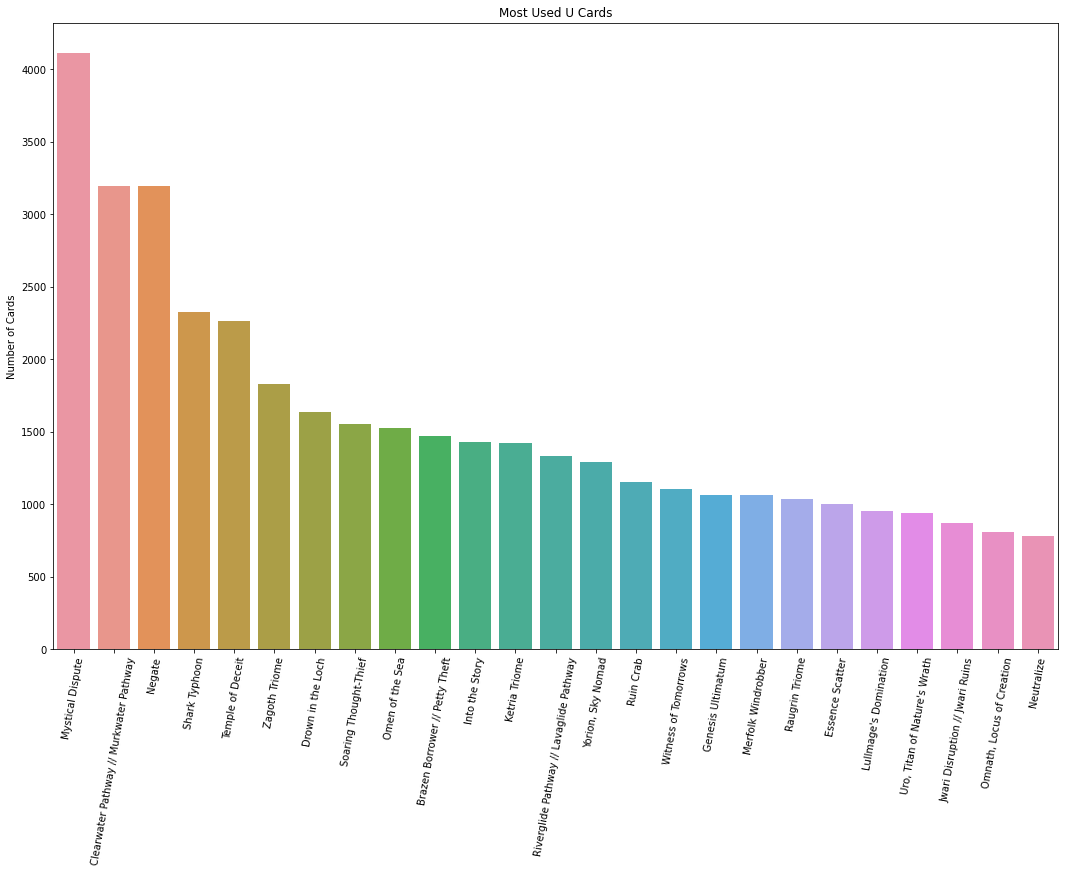

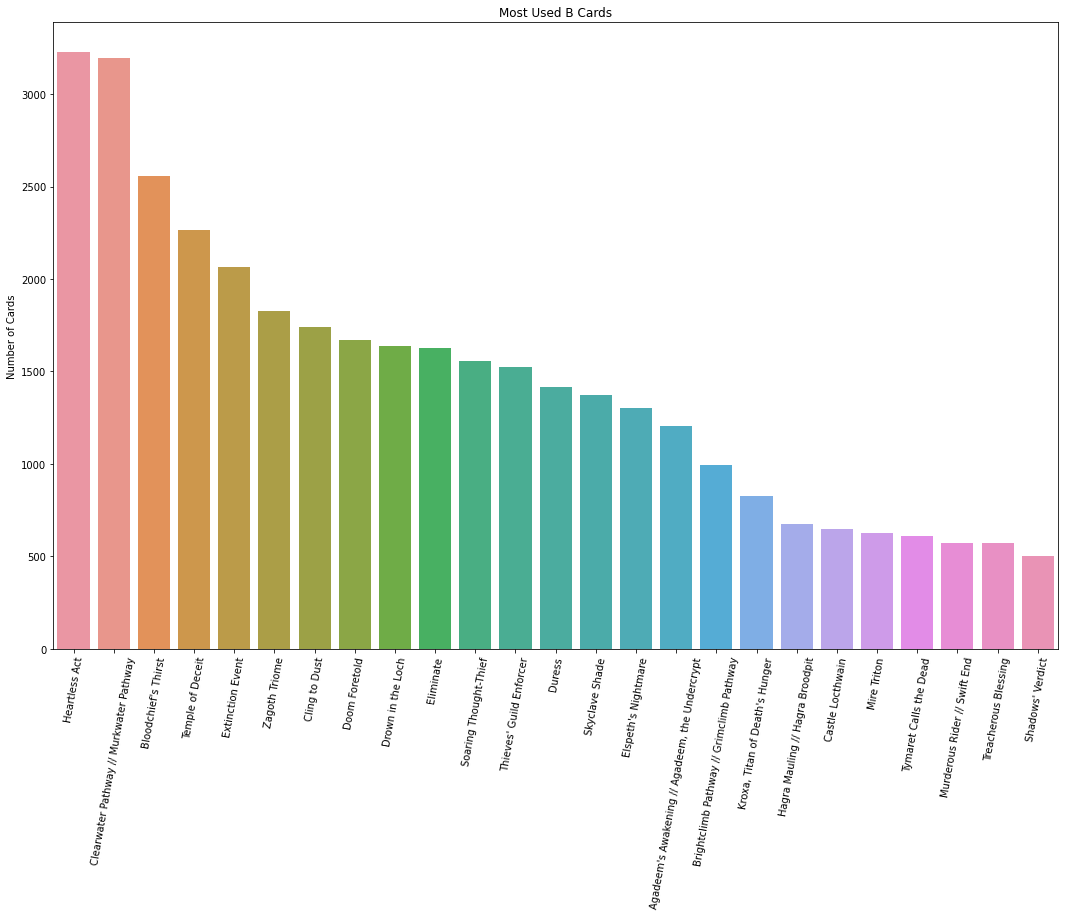

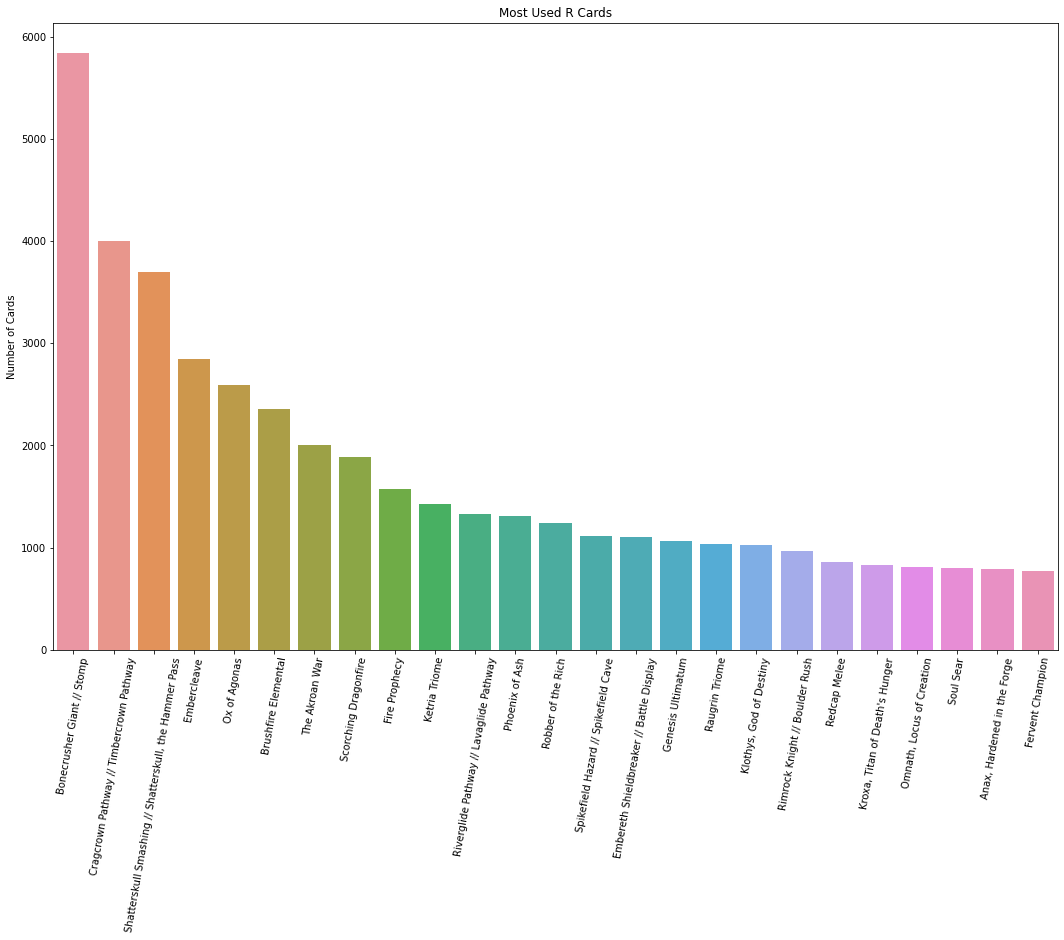

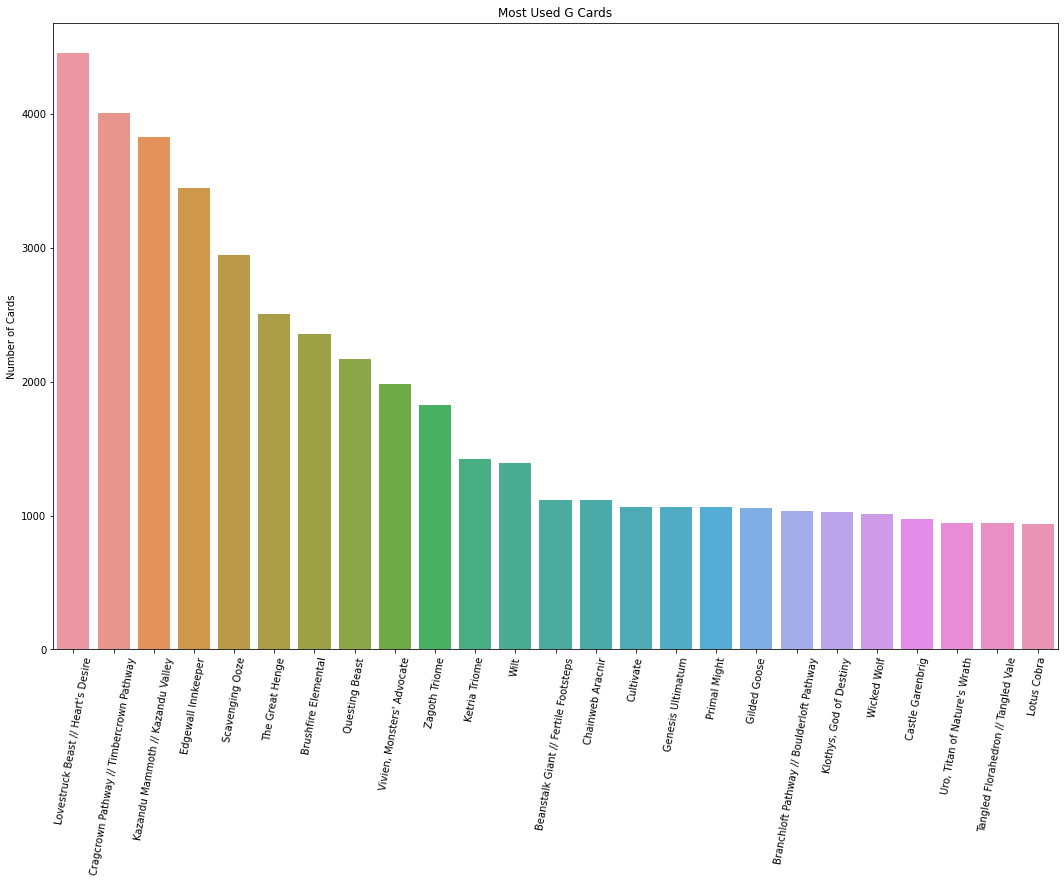

In [47]:
plot_color_dominance(full_table, show=True)

In [48]:
def set_dominance(df, set_code, show=False):
    this_df = df.copy().fillna("")
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    set_df = this_df[
        (this_df["set"] == set_code)
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
        & (~this_df["name"].str.contains("Snow-Covered"))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=set_df, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"Most Used Cards from {set_code.title()} Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()

In [49]:
def plot_set_dominance(df, show=False, pdf=None):
    for set_code in ["eld", "thb", "iko", "znr", "m21", "khm"]:
        set_dominance(df, set_code, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

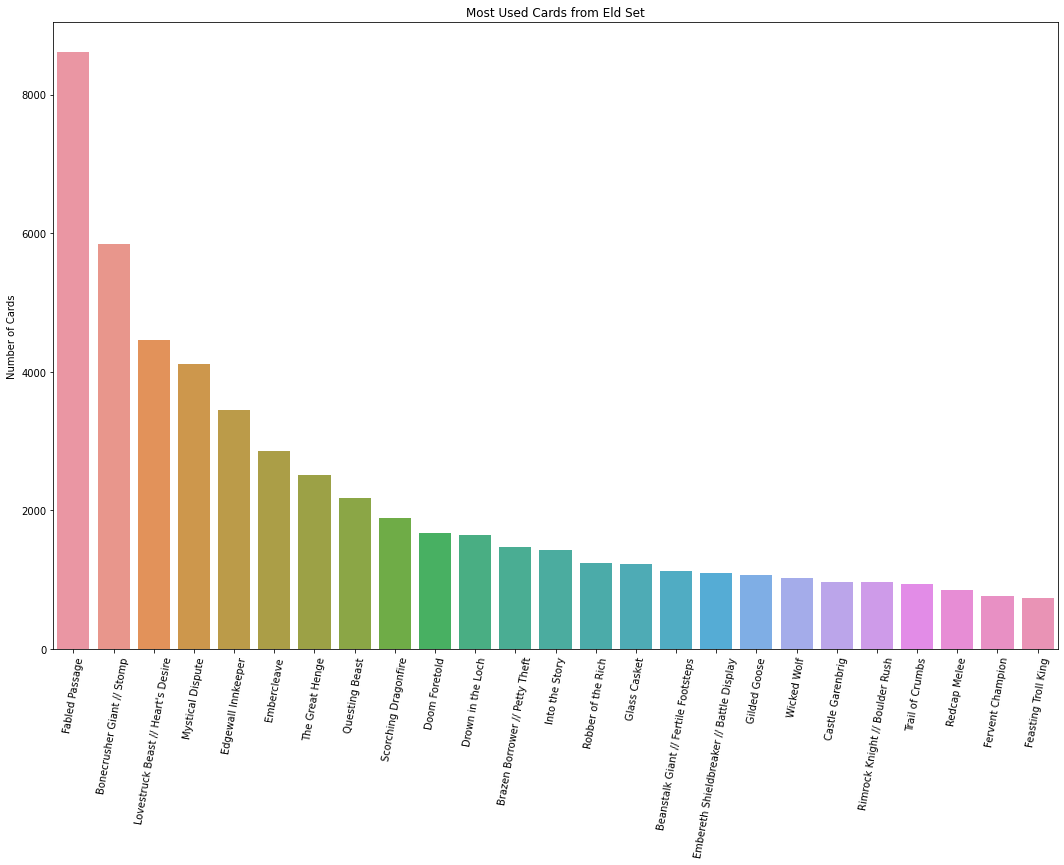

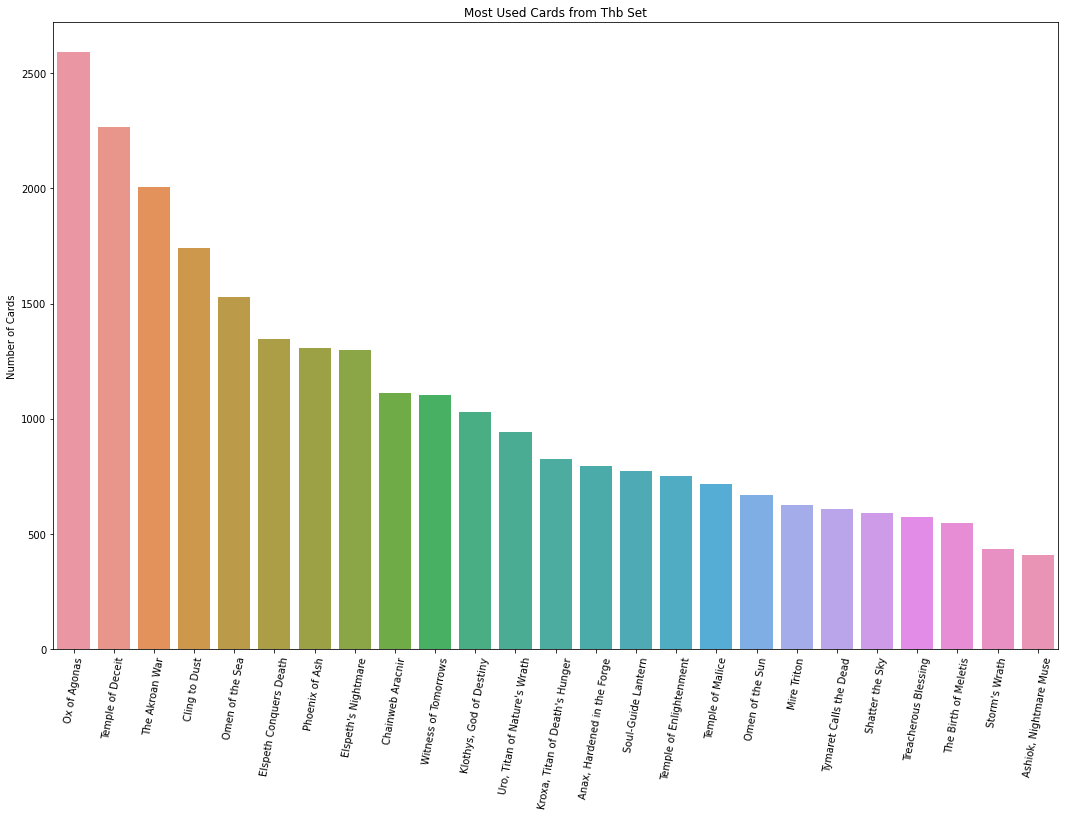

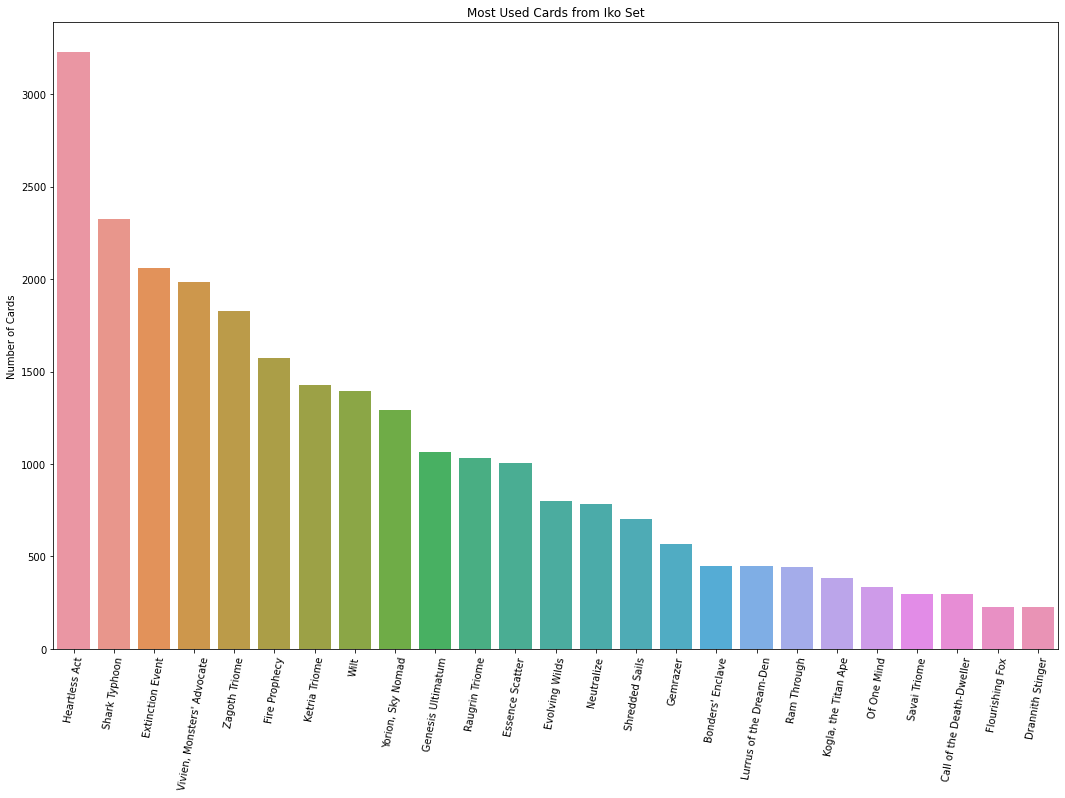

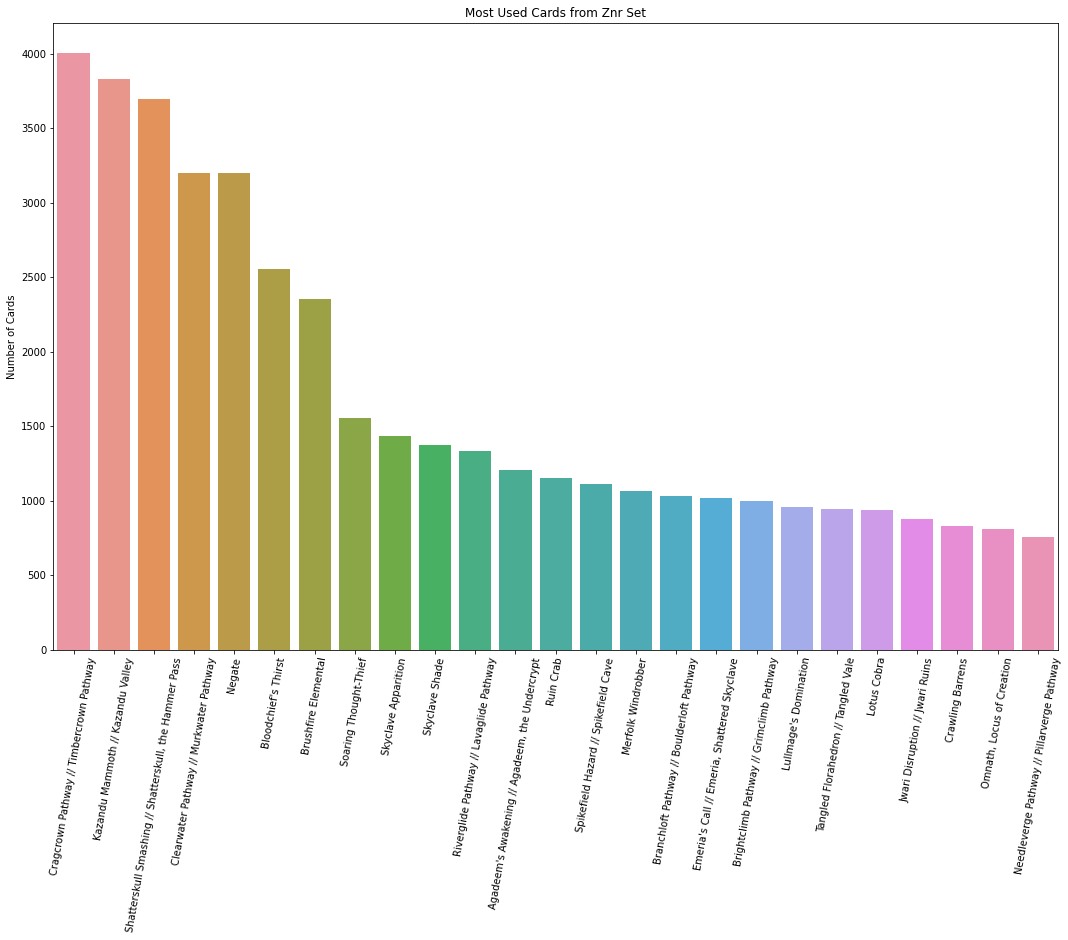

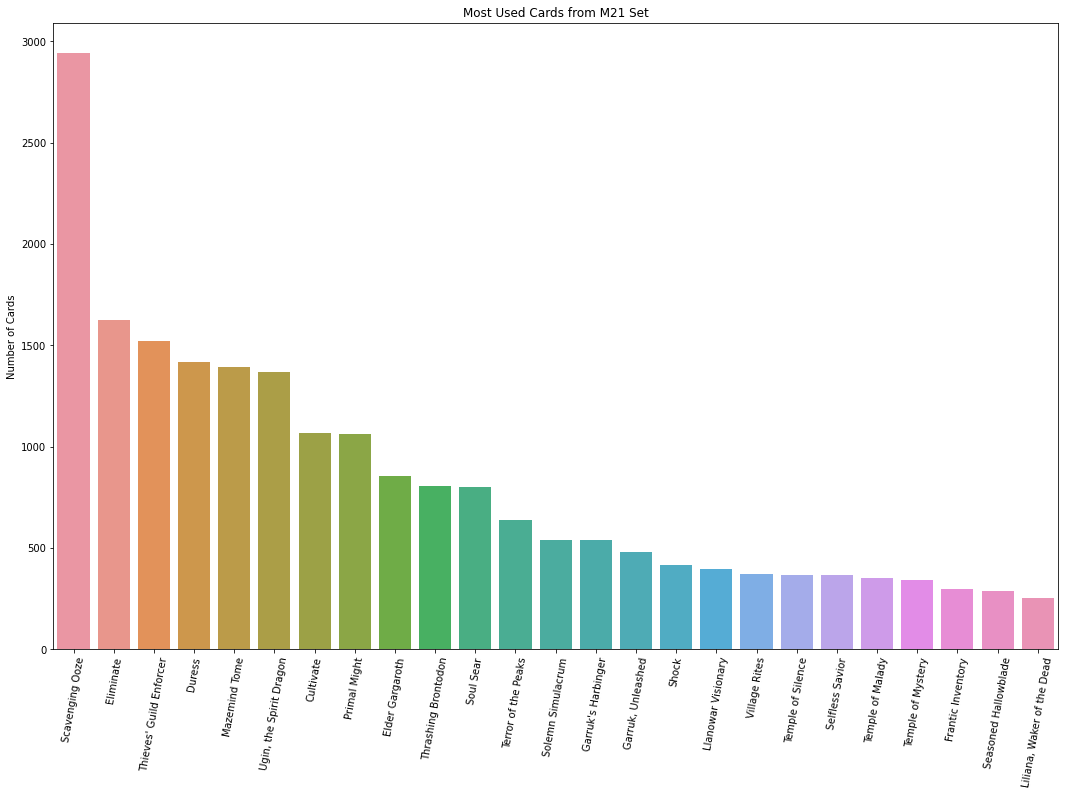

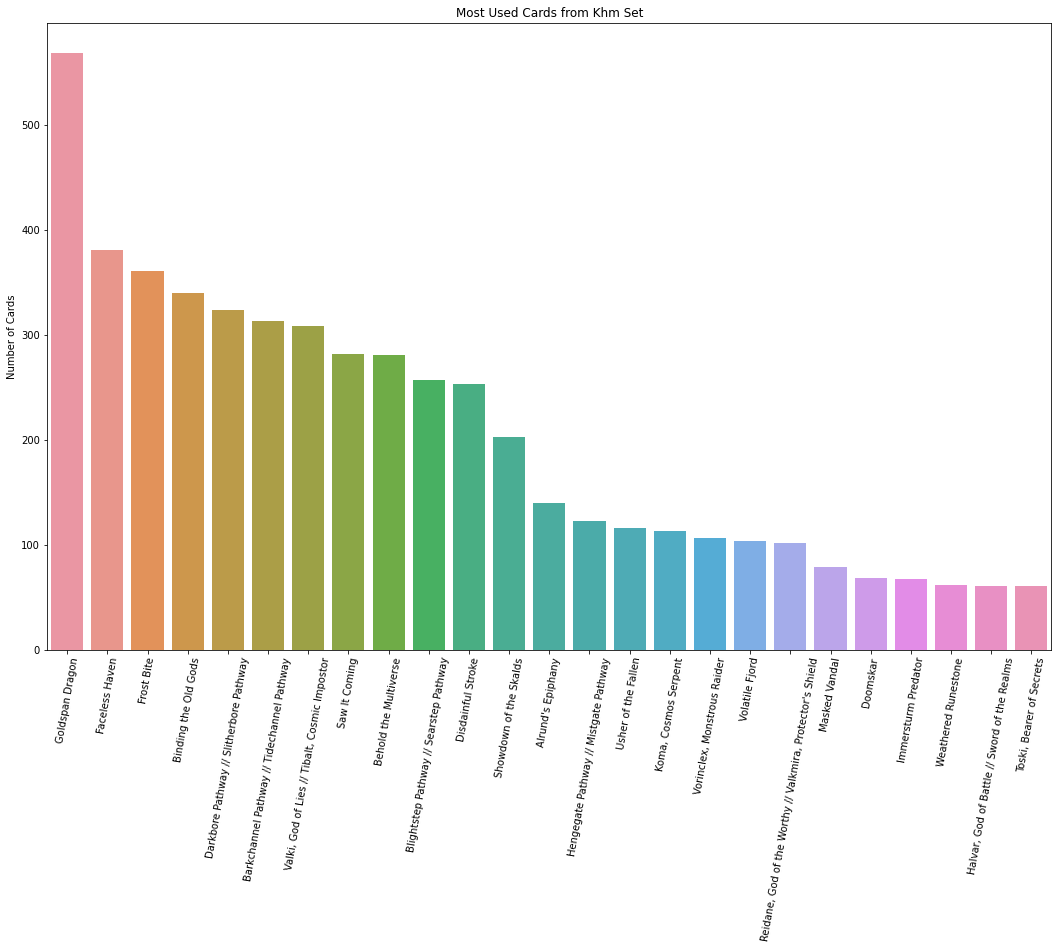

In [50]:
plot_set_dominance(full_table, show=True)

In [51]:
def oracle_text_analysis(df=most_used_cards):
    this_df = (
        df[["name"]]
        .merge(card_table[["name", "oracle_text"]], on="name", how="left")
        .drop_duplicates()
        .copy()
    )
    return this_df[
        (~this_df["name"].str.contains("Triome|Pathway|Fabled Passage", regex=True))
    ]

In [52]:
oracle_texts = oracle_text_analysis()

In [53]:
oracle_texts

name  \
4                                     Bonecrusher Giant // Stomp   
6         Shatterskull Smashing // Shatterskull, the Hammer Pass   
8                             Lovestruck Beast // Heart's Desire   
10                             Kazandu Mammoth // Kazandu Valley   
12                                               The Great Henge   
14                                                 Heartless Act   
18                                                   Embercleave   
20                                               Scavenging Ooze   
25                                            Edgewall Innkeeper   
26                                           Bloodchief's Thirst   
28                                              Temple of Deceit   
31                                                Questing Beast   
33                                           Brushfire Elemental   
37                                    Vivien, Monsters' Advocate   
39                Agadeem's Awakening // Agadeem, the Undercrypt   
41                                                     Eliminate   
43                                             Drown in the Loch   
44                                              Extinction Event   
46                                              Castle Locthwain   
48                                               Essence Scatter   
54                                         Soaring Thought-Thief   
55                                       Thieves' Guild Enforcer   
57                                                Into the Story   
58                                                 Shark Typhoon   
60                                               Omen of the Sea   
61                                                 Cling to Dust   
62                                                The Akroan War   
63                                              Crawling Barrens   
65                                           Skyclave Apparition   
67                   Emeria's Call // Emeria, Shattered Skyclave   
69                               Hagra Mauling // Hagra Broodpit   
71                                                 Mazemind Tome   
73                                           Elspeth's Nightmare   
74                                        Elspeth Conquers Death   
75                                                        Negate   
88                                                  Primal Might   
90                                                 Fire Prophecy   
93                                Brazen Borrower // Petty Theft   
95                                             Yorion, Sky Nomad   
97                                       Ugin, the Spirit Dragon   
101                               Rimrock Knight // Boulder Rush   
103                                           Merfolk Windrobber   
104                              Jwari Disruption // Jwari Ruins   
105                                           Robber of the Rich   
107                                                    Ruin Crab   
109                         Spikefield Hazard // Spikefield Cave   
112                          Tangled Florahedron // Tangled Vale   
113                                                 Gilded Goose   
115                                               Evolving Wilds   
124                                                 Glass Casket   
126                                              Trail of Crumbs   
127                                                  Wicked Wolf   
129                                             Castle Garenbrig   
131                                              Castle Vantress   
133                                              Omen of the Sun   
134                                             Mystical Dispute   
135                     Embereth Shieldbreaker // Battle Display   
137                                        Lullmage's Domination   
140                                             

In [54]:
help(wordnet.synsets)

Help on method synsets in module nltk.corpus.reader.wordnet:

synsets(lemma, pos=None, lang='eng', check_exceptions=True) method of nltk.corpus.reader.wordnet.WordNetCorpusReader instance
    Load all synsets with a given lemma and part of speech tag.
    If no pos is specified, all synsets for all parts of speech
    will be loaded.
    If lang is specified, all the synsets associated with the lemma name
    of that language will be returned.



In [55]:
wordnet.synsets("enter")

[Synset('enter.v.01'),
 Synset('enter.v.02'),
 Synset('enroll.v.01'),
 Synset('figure.v.02'),
 Synset('record.v.01'),
 Synset('enter.v.06'),
 Synset('accede.v.02'),
 Synset('insert.v.01'),
 Synset('embark.v.02')]

In [56]:
def get_part_of_speech(word):
    
    # wordnet.synsets(word) returns a list of all the available synonyms in ntlk corpus
    probable_part_of_speech = wordnet.synsets(word)

    pos_counts = Counter()
    
    # Gets the number of times each word is labeled as "n", "v", "a", or "r" in synsets
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    
    # The most common item in Counter is the one with the most synsets of a particular pos
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

In [57]:
def process_text(text):
    cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', "", text)
    tokenized = word_tokenize(cleaned)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    return [word.lower() for word in lemmatized if word not in stop_words]

In [58]:
def get_tf_idf_scores(corpus):
    processed_corpus = [process_text(text) for text in corpus]
    vectorizer = TfidfVectorizer(norm=None, lowercase=None)
    tfidf_scores = vectorizer.fit_transform(processed_corpus)
    return tfidf_scores

In [59]:
texts = oracle_texts["oracle_text"].fillna("").tolist()
# processed_texts = [process_text(text) for text in texts]

In [60]:
texts

["Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target.",
 "Shatterskull Smashing deals X damage divided as you choose among up to two target creatures and/or planeswalkers. If X is 6 or more, Shatterskull Smashing deals twice X damage divided as you choose among them instead. // As Shatterskull, the Hammer Pass enters the battlefield, you may pay 3 life. If you don't, it enters the battlefield tapped.\n{T}: Add {R}.",
 "Lovestruck Beast can't attack unless you control a 1/1 creature. // Create a 1/1 white Human creature token. (Then exile this card. You may cast the creature later from exile.)",
 'Landfall — Whenever a land enters the battlefield under your control, Kazandu Mammoth gets +2/+2 until end of turn. // Kazandu Valley enters the battlefield tapped.\n{T}: Add {G}.',
 'This spell costs {X} less to cast, where X is the greatest power amon

In [61]:
test_vectorizer = TfidfVectorizer(norm=None, stop_words=stopwords.words("english"))
tfidf_scores = test_vectorizer.fit_transform(texts)

In [62]:
test_vectorizer.get_feature_names()

['10',
 '15',
 '20',
 'abandon',
 'abilities',
 'ability',
 'able',
 'acclaimed',
 'acolyte',
 'acquisitions',
 'activate',
 'activated',
 'adamant',
 'add',
 'addition',
 'additional',
 'adds',
 'adventure',
 'affected',
 'affliction',
 'agadeem',
 'agonas',
 'akoum',
 'akroan',
 'aldergard',
 'alirios',
 'ally',
 'almighty',
 'alpine',
 'alrund',
 'alseid',
 'also',
 'among',
 'amount',
 'amulet',
 'anax',
 'ancient',
 'ancients',
 'angel',
 'angels',
 'another',
 'anything',
 'anywhere',
 'ape',
 'apex',
 'apparition',
 'apply',
 'apprentice',
 'aracnir',
 'arcanist',
 'archfiend',
 'archmage',
 'archon',
 'archpriest',
 'arctic',
 'ardenvale',
 'aris',
 'arni',
 'arsonist',
 'artifact',
 'artifacts',
 'artisan',
 'ascendant',
 'ash',
 'ashaya',
 'ashiok',
 'asphodel',
 'aspirant',
 'assign',
 'athreos',
 'atris',
 'attach',
 'attached',
 'attack',
 'attacked',
 'attacking',
 'attacks',
 'aura',
 'axe',
 'ayara',
 'backwater',
 'bala',
 'baloth',
 'banishing',
 'banner',
 'bargain',

In [63]:
test_vectorizer.vocabulary_

{'whenever': 1185,
 'bonecrusher': 132,
 'giant': 454,
 'becomes': 102,
 'target': 1043,
 'spell': 988,
 'deals': 262,
 'damage': 254,
 'controller': 216,
 'prevented': 806,
 'turn': 1107,
 'stomp': 1013,
 'shatterskull': 939,
 'smashing': 971,
 'divided': 291,
 'choose': 183,
 'among': 32,
 'two': 1115,
 'creatures': 244,
 'planeswalkers': 789,
 'twice': 1114,
 'instead': 558,
 'hammer': 501,
 'pass': 768,
 'enters': 352,
 'battlefield': 96,
 'may': 665,
 'pay': 770,
 'life': 618,
 'tapped': 1041,
 'add': 13,
 'lovestruck': 641,
 'beast': 100,
 'attack': 73,
 'unless': 1131,
 'control': 214,
 'creature': 243,
 'create': 241,
 'white': 1188,
 'human': 534,
 'token': 1074,
 'exile': 374,
 'card': 152,
 'cast': 157,
 'later': 606,
 'landfall': 602,
 'land': 601,
 'kazandu': 579,
 'mammoth': 654,
 'gets': 449,
 'end': 345,
 'valley': 1145,
 'costs': 228,
 'less': 613,
 'greatest': 482,
 'power': 799,
 'gain': 433,
 'nontoken': 732,
 'put': 817,
 'counter': 231,
 'draw': 306,
 'one': 743,


In [64]:
corpus = " ".join(oracle_texts["oracle_text"].fillna(""))

In [65]:
corpus

'Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell\'s controller. // Damage can\'t be prevented this turn. Stomp deals 2 damage to any target. Shatterskull Smashing deals X damage divided as you choose among up to two target creatures and/or planeswalkers. If X is 6 or more, Shatterskull Smashing deals twice X damage divided as you choose among them instead. // As Shatterskull, the Hammer Pass enters the battlefield, you may pay 3 life. If you don\'t, it enters the battlefield tapped.\n{T}: Add {R}. Lovestruck Beast can\'t attack unless you control a 1/1 creature. // Create a 1/1 white Human creature token. (Then exile this card. You may cast the creature later from exile.) Landfall — Whenever a land enters the battlefield under your control, Kazandu Mammoth gets +2/+2 until end of turn. // Kazandu Valley enters the battlefield tapped.\n{T}: Add {G}. This spell costs {X} less to cast, where X is the greatest power among creatures y

In [66]:
def make_ngram_df(text_series, n):
    text_series = text_series.fillna("")
    text = " ".join(text_series)
#     cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', '', text)
#     tokenized = word_tokenize(cleaned)
    
#     lemmatizer = WordNetLemmatizer()
#     lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    
#     stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    real_text = process_text(text)
    
    bigrams = [" ".join(gram) for gram in ngrams(real_text, n)]
    
    freq = Counter(bigrams)
    
    df = (
        pd.DataFrame(
            {
                "bigram": freq.keys(),
                "freq": freq.values()
            }
        )
        .sort_values(by="freq", ascending=False)
        .iloc[:100]
    )
    df["pct_total"] = df["freq"] / df["freq"].sum() * 100
    
    return df

In [67]:
bigrams = make_ngram_df(oracle_texts["oracle_text"], 2)

In [68]:
bigrams

bigram  freq  pct_total
43        enter battlefield   303   7.159735
28          target creature   192   4.536862
88                 end turn   132   3.119093
119               draw card   130   3.071834
73                  you may   115   2.717391
104        creature control   108   2.551985
53                    t add   108   2.551985
117            +1+1 counter   108   2.551985
153          card graveyard    96   2.268431
51          battlefield tap    94   2.221172
68           creature token    87   2.055766
184               mana cost    71   1.677694
179              cast spell    65   1.535917
384            discard card    58   1.370510
202            card library    58   1.370510
116                put +1+1    54   1.275992
183            convert mana    54   1.275992
441        opponent control    53   1.252363
898                at begin    52   1.228733
347                two card    51   1.205104
74                 may cast    50   1.181474
82      battlefield control    48   1.134216
142            creature get    47   1.110586
128          counter target    44   1.039698
156           creature card    44   1.039698
17            damage target    43   1.016068
123          destroy target    42   0.992439
277        onto battlefield    42   0.992439
45                  may pay    41   0.968809
71               exile card    41   0.968809
162                  1 life    41   0.968809
181   creature planeswalker    40   0.945180
52                    tap t    36   0.850662
754             t sacrifice    36   0.850662
200                look top    36   0.850662
143                get +1+1    36   0.850662
271          search library    35   0.827032
327               card hand    35   0.827032
1156      whenever creature    35   0.827032
108                you gain    34   0.803403
449             deal damage    32   0.756144
203             library you    32   0.756144
279         shuffle library    32   0.756144
338             control get    32   0.756144
47                   3 life    31   0.732514
163           whenever cast    31   0.732514
207          bottom library    31   0.732514
204                 may put    30   0.708885
151            exile target    29   0.685255
221           combat damage    29   0.685255
569           return target    28   0.661626
157                card put    28   0.661626
75            cast creature    28   0.661626
216              cant block    28   0.661626
616                put hand    27   0.637996
4              target spell    27   0.637996
542         target opponent    27   0.637996
121              choose one    27   0.637996
385               card draw    26   0.614367
683        activate ability    26   0.614367
110                  2 life    26   0.614367
98                less cast    26   0.614367
205                put card    26   0.614367
64                create 11    26   0.614367
599              owner hand    25   0.590737
161                  gain 1    25   0.590737
718              three card    25   0.590737
671           damage player    25   0.590737
2464       enchant creature    24   0.567108
770               land card    23   0.543478
201                top card    23   0.543478
1376      nonhuman creature    23   0.543478
1393             put target    22   0.519849
332                 as long    22   0.519849
229             deal combat    22   0.519849
377               token fly    22   0.519849
1141               x number    22   0.519849
65                 11 white    21   0.496219
94               this spell    21   0.496219
476              one target    21   0.496219
412               cast card    20   0.472590
195                tap when    20   0.472590
404                  gain 3    20   0.472590
282   graveyard battlefield    20   0.472590
92                    add g    20   0.472590
976      sacrifice creature    20   0.472590
218          creature power    20   0.472590
515              basic land    20   0.472590
1502            

In [69]:
trigrams = make_ngram_df(oracle_texts["oracle_text"], 3)

In [70]:
trigrams

bigram  freq  pct_total
55           enter battlefield tap    77   3.900709
125               put +1+1 counter    54   2.735562
207              convert mana cost    54   2.735562
78                    you may cast    43   2.178318
87       enter battlefield control    40   2.026342
155        target creature control    38   1.925025
56               battlefield tap t    36   1.823708
57                       tap t add    35   1.773050
230                library you may    30   1.519757
204   target creature planeswalker    28   1.418440
229               card library you    26   1.317123
179                    gain 1 life    25   1.266464
465                 card draw card    24   1.215805
132        destroy target creature    23   1.165147
464              discard card draw    23   1.165147
843           combat damage player    23   1.165147
263             deal combat damage    22   1.114488
455             creature token fly    22   1.114488
228               top card library    21   1.063830
502                  may cast card    20   1.013171
138        counter target creature    20   1.013171
491                    gain 3 life    20   1.013171
98                         t add g    20   1.013171
220           battlefield tap when    19   0.962513
1014           rest bottom library    19   0.962513
3268               at begin upkeep    19   0.962513
117                    gain 2 life    18   0.911854
231                    you may put    18   0.911854
323           put onto battlefield    18   0.911854
733         damage target creature    18   0.911854
1033       indestructible end turn    18   0.911854
77                    card you may    18   0.911854
79               may cast creature    18   0.911854
500             card graveyard you    18   0.911854
86          land enter battlefield    18   0.911854
1940       creature card graveyard    18   0.911854
237                        t add u    17   0.861196
342                        t add b    17   0.861196
512                  step add lore    17   0.861196
832            target creature get    17   0.861196
513               add lore counter    17   0.861196
514         lore counter sacrifice    17   0.861196
511                  draw step add    17   0.861196
510                enter draw step    17   0.861196
509                saga enter draw    17   0.861196
508                  as saga enter    17   0.861196
8                    deal 2 damage    17   0.861196
101                this spell cost    17   0.861196
1416        enter battlefield draw    17   0.861196
85             whenever land enter    17   0.861196
1800          library random order    17   0.861196
1992      target nonhuman creature    17   0.861196
1799         bottom library random    17   0.861196
1998              top plus ability    16   0.810537
76                  exile card you    16   0.810537
75                 then exile card    16   0.810537
971                basic land card    16   0.810537
80              cast creature late    16   0.810537
81             creature late exile    16   0.810537
197                    you may pay    16   0.810537
515          counter sacrifice iii    16   0.810537
516                sacrifice iii i    16   0.810537
1991           put target nonhuman    16   0.810537
1996           mutate creature top    16   0.810537
779                time could cast    16   0.810537
1997             creature top plus    16   0.810537
143                    cost 1 less    16   0.810537
1994          creature they mutate    16   0.810537
501              graveyard you may    16   0.810537
332           target creature card    16   0.810537
2080                     may pay 2    16   0.810537
1986                 if cast spell    16   0.810537
1987             cast spell mutate    16   0.810537
1993        nonhuman creature they    16   0.810537
1988             spell mutate cost    16   0.810537
1989               mutate cost put    16   0.810537
1990               cost 

In [71]:
unigrams = make_ngram_df(oracle_texts["oracle_text"], 1)

In [72]:
unigrams

bigram  freq  pct_total
21       creature   731   6.207541
54           card   676   5.740489
4          target   406   3.447690
46        control   395   3.354280
32    battlefield   394   3.345788
31          enter   322   2.734375
12           turn   269   2.284307
75            put   242   2.055027
56           cast   228   1.936141
77        counter   219   1.859715
33            may   208   1.766304
5           spell   204   1.732337
0        whenever   197   1.672894
85           when   192   1.630435
39              t   190   1.613451
78           draw   187   1.587976
53          exile   177   1.503057
55            you   177   1.503057
114       library   177   1.503057
93      graveyard   164   1.392663
73           gain   159   1.350204
68           cost   156   1.324728
64            end   153   1.299253
125      opponent   148   1.256793
40            add   146   1.239810
36           life   146   1.239810
76           +1+1   145   1.231318
7               2   143   1.214334
8          damage   142   1.205842
84              1   140   1.188859
157          hand   135   1.146399
6            deal   132   1.120924
24             if   132   1.120924
107          mana   129   1.095448
38            tap   127   1.078465
62            get   123   1.044497
185     sacrifice   119   1.010530
51          token   117   0.993546
20            two   114   0.968071
48         create   112   0.951087
127        player   105   0.891644
79            one   102   0.866168
213     permanent   100   0.849185
16              x    96   0.815217
113           top    88   0.747283
59           land    86   0.730299
35              3    82   0.696332
44         attack    77   0.653872
179       discard    76   0.645380
272       ability    75   0.636889
69           less    72   0.611413
142        number    72   0.611413
158        flying    72   0.611413
34            pay    70   0.594429
18         choose    70   0.594429
141        return    70   0.594429
445        mutate    68   0.577446
10           cant    65   0.551970
167       another    62   0.526495
71          power    61   0.518003
80        destroy    58   0.492527
28             as    58   0.492527
105  planeswalker    54   0.458560
255         begin    54   0.458560
106       convert    54   0.458560
322            at    52   0.441576
146         equal    52   0.441576
292      artifact    51   0.433084
156          lose    51   0.433084
176           fly    47   0.399117
82          three    47   0.399117
123        combat    46   0.390625
91        trample    46   0.390625
49          white    46   0.390625
472       enchant    45   0.382133
191          step    44   0.373641
139          onto    44   0.373641
231        reveal    44   0.373641
122         block    44   0.373641
120         haste    43   0.365149
285           die    43   0.365149
352   enchantment    43   0.365149
47             11    41   0.348166
111          scry    40   0.339674
262         color    40   0.339674
271      activate    39   0.331182
27        instead    39   0.331182
112          look    38   0.322690
138        search    37   0.314198
140       shuffle    37   0.314198
67           this    37   0.314198
403          type    36   0.305707
19          among    36   0.305707
333      lifelink    36   0.305707
159          long    36   0.305707
37           dont    36   0.305707
83          flash    36   0.305707
204             4    35   0.297215
108          kick    35   0.297215
202          each    34   0.288723

In [73]:
def topn_analyze_card_text_by_archetype(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        archetype_df = get_most_used_cards(df[df["archetype"]==archetype])
        oracle_text_df = oracle_text_analysis(archetype_df)
        bigrams = make_ngram_df(oracle_text_df["oracle_text"], 2)
        plt.figure(figsize=(18, 15))
        sns.barplot(data=bigrams.iloc[:10], x="bigram", y="pct_total")
        plt.title(f"Bigrams for {archetype.title()}")
        plt.xticks(rotation=80)
        plt.xlabel("")
        plt.ylabel("Percent of Total")
        if show:
            plt.show()
        if pdf:
            pdf.savefig()
            plt.close("all")

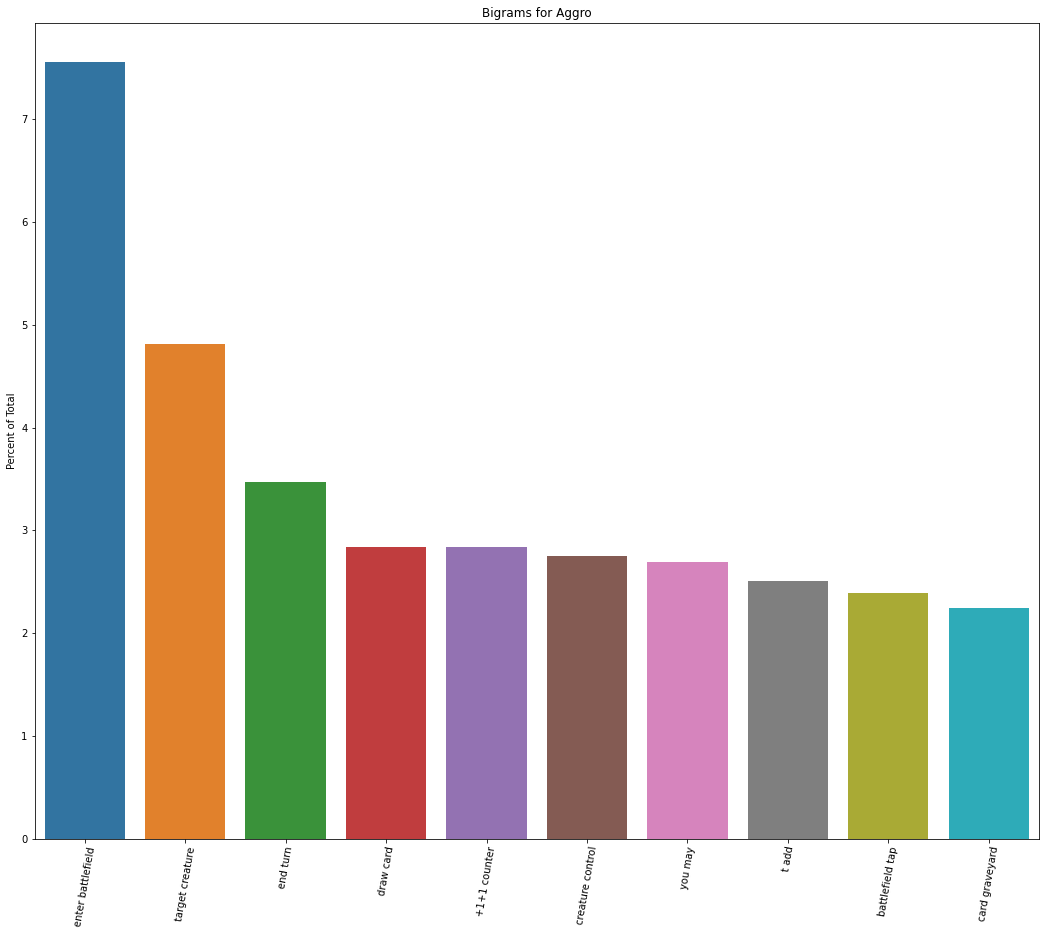

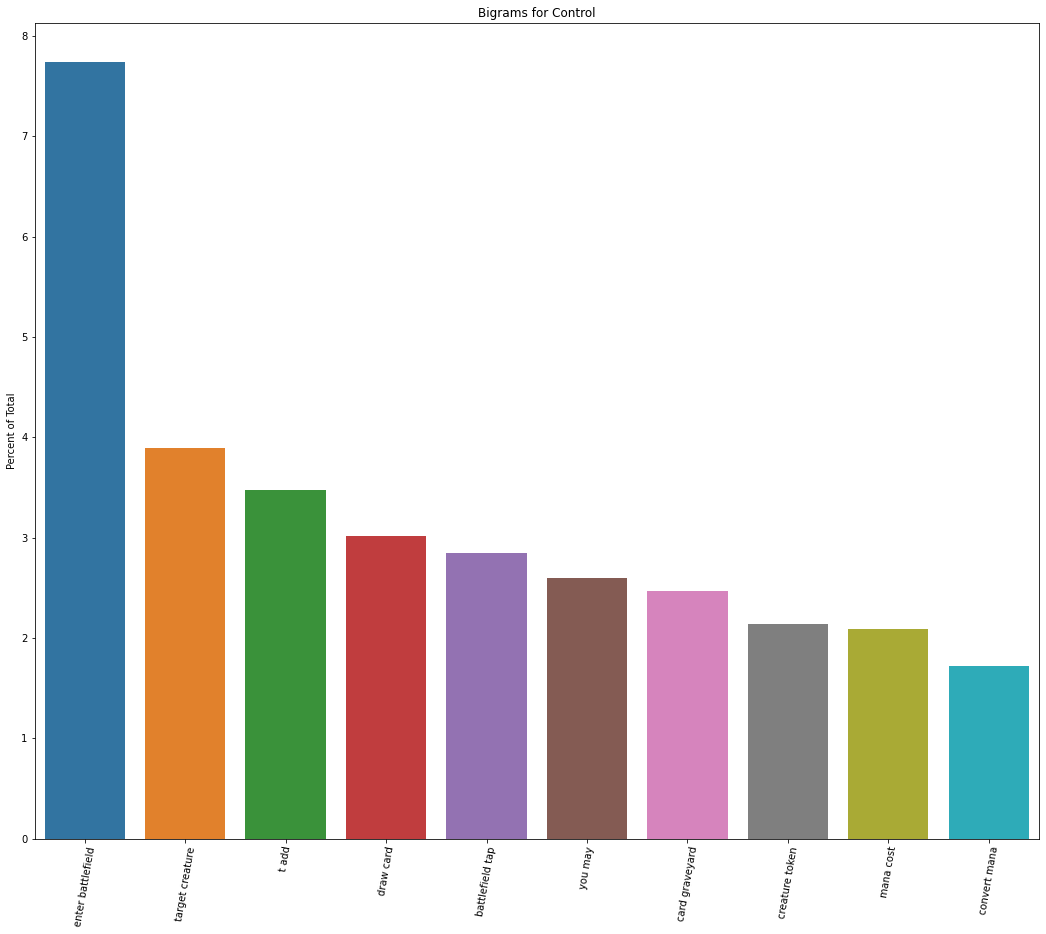

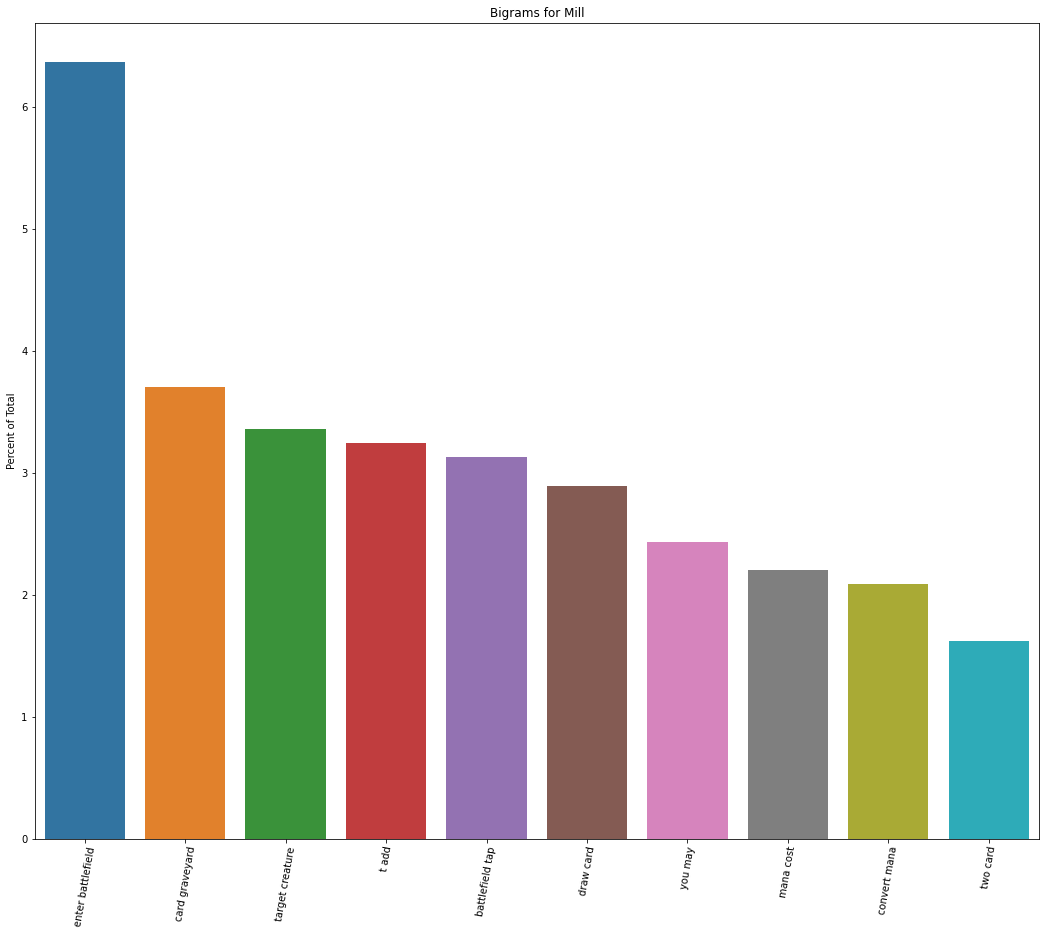

In [74]:
topn_analyze_card_text_by_archetype(main_decks, n=3, show=True)

In [75]:
oracle_texts[oracle_texts["oracle_text"].str.contains("\send\s.*\sturn[\s\.]", regex=True, flags=re.I)]

name  \
10        Kazandu Mammoth // Kazandu Valley   
33                      Brushfire Elemental   
63                         Crawling Barrens   
88                             Primal Might   
101          Rimrock Knight // Boulder Rush   
127                             Wicked Wolf   
169                    Kogla, the Titan Ape   
176                         Castle Embereth   
183                        Fervent Champion   
212                          Phoenix of Ash   
216                          Faceless Haven   
263                         Akoum Hellhound   
270                           Dream Trawler   
282                         Selfless Savior   
289                    Binding the Old Gods   
292                     Claim the Firstborn   
310                      Kargan Intimidator   
315                    Seasoned Hallowblade   
354                         Footfall Crater   
366                 Alseid of Life's Bounty   
402                  Elspeth, Sun's Nemesis   
425                       Garruk, Unleashed   
428                               Soul Sear   
478                     Immersturm Predator   
488                   Erebos's Intervention   
504                           Glory Bearers   
514                       Weaselback Redcap   
529              Kenrith, the Returned King   
543                         Felidar Retreat   
545                        The Royal Scions   
553                    Koma, Cosmos Serpent   
563                Winota, Joiner of Forces   
567                       Grasp of Darkness   
572                        Zulaport Duelist   
576        Sejiri Shelter // Sejiri Glacier   
587                         Arni Brokenbrow   
593                           Massacre Wurm   
601   Faerie Guidemother // Gift of the Fae   
634                          Blizzard Brawl   
664                               Infuriate   
666                          Ranger's Guile   
678                Nissa of Shadowed Boughs   
685            Vito, Thorn of the Dusk Rose   
694                            Fight as One   
716                             Shadowspear   
718                          Snakeskin Veil   
735                          Pestilent Haze   
755                     Firja's Retribution   
756                               Basri Ket   
766    Song-Mad Treachery // Song-Mad Ruins   
767                              Bolt Hound   
778                      Blacklance Paragon   
783                      Archpriest of Iona   
789                      Fearless Fledgling   
800                         Bronzehide Lion   
813                            Fearless Pup   
825       Makindi Stampede // Makindi Mesas   
831                        Wildwood Tracker   
846                           Crash Through   
858                    Reptilian Reflection   
870                  Watcher of the Spheres   
888                            Raking Claws   
896                        Stormwing Entity   
900                          Crippling Fear   
925                            Unleash Fury   
939             Beyeen Veil // Beyeen Coast   
972                         Master of Winds   
974                      Almighty Brushwagg   
989                       Sea Gate Banneret   
1002                      Witch's Vengeance   
1009                Akiri, Fearless Voyager   
1028                         Starlit Mantle   
1029                          Canopy Baloth   
1044                          Discontinuity   
1059                         Shadow Stinger   
1082                        Goblin Wizardry   
1090                      Masked Blackguard   
1101                            Igneous Cur   
1108                    Heroic Intervention   
1121                          Righteousness   
1123                             Riddleform   
1130                            Grim Draugr   
1133                        Resolute Strike   
1136                    Heartfire Immolator   
1161                       Traitorous Greed 

In [76]:
full_table_oracle_text = oracle_text_analysis(full_table)

In [77]:
full_table_oracle_text

name  \
6                            Forest   
151                        Mountain   
296      Bonecrusher Giant // Stomp   
298             Brushfire Elemental   
300              Edgewall Innkeeper   
...                             ...   
1159523         Resplendent Marshal   
1159525             Rally the Ranks   
1170112         Bloodline Pretender   
1170113             Vengeful Reaper   
1170114           Youthful Valkyrie   

                                                                                                                                                                                                                                                                      oracle_text  
6                                                                                                                                                                                                                                                                 ({T}: Add {G}.)  
151                                                                                                                                                                                                                                                               ({T}: Add {R}.)  
296                                                                            Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target.  
298                                                                       Haste\nBrushfire Elemental can't be blocked by creatures with power 2 or less.\nLandfall — Whenever a land enters the battlefield under your control, Brushfire Elemental gets +2/+2 until end of turn.  
300                                                                                                                                                 Whenever you cast a creature spell that has an Adventure, draw a card. (It doesn't need to have gone on the adventure first.)  
...                                                                                                                                                                                                                                                                           ...  
1159523  Flying\nWhen Resplendent Marshal enters the battlefield or dies, you may exile another creature card from your graveyard. When you do, put a +1/+1 counter on each creature you control other than Resplendent Marshal that shares a creature type with the exiled card.  
1159525                                                                                                                                                   As Rally the Ranks enters the battlefield, choose a creature type.\nCreatures you control of the chosen type get +1/+1.  
1170112               Changeling (This card is every creature type.)\nAs Bloodline Pretender enters the battlefield, choose a creature type.\nWhenever another creature of the chosen type enters the battlefield under your control, put a +1/+1 counter on Bloodline Pretender.  
1170113                                                                                               Flying, deathtouch, haste\nForetell {1}{B} (During your turn, you may pay {2} and exile this card from your hand face down. Cast it on a later turn for its foretell cost.)  
1170114                                                                                                                                                       Flying\nWhenever another Angel enters the battlefield under your control, put a +1/+1 counter on Youthful Valkyrie.  

[1073 rows x 2 columns]

In [78]:
make_ngram_df(full_table_oracle_text["oracle_text"], 2)

bigram  freq  pct_total
36        enter battlefield   397   7.009181
114         target creature   264   4.661017
42                 end turn   177   3.125000
83                  you may   161   2.842514
129            +1+1 counter   160   2.824859
49                draw card   157   2.771893
97         creature control   148   2.612994
0                     t add   132   2.330508
123          card graveyard   128   2.259887
63          battlefield tap   114   2.012712
78           creature token   110   1.942090
799              cast spell   103   1.818503
346               mana cost   100   1.765537
315            card library    81   1.430085
128                put +1+1    79   1.394774
299        opponent control    77   1.359463
84                 may cast    73   1.288842
360            discard card    71   1.253531
345            convert mana    71   1.253531
22            damage target    69   1.218220
229                at begin    67   1.182910
353          destroy target    65   1.147599
910                two card    65   1.147599
430          counter target    64   1.129944
115            creature get    61   1.076977
81               exile card    59   1.041667
169                 may pay    58   1.024011
267   creature planeswalker    57   1.006356
37      battlefield control    57   1.006356
126           creature card    55   0.971045
313                look top    52   0.918079
308             deal damage    52   0.918079
349        onto battlefield    49   0.865113
393                 may put    47   0.829802
425               card hand    47   0.829802
134                  1 life    46   0.812147
208                you gain    45   0.794492
855             t sacrifice    44   0.776836
762              choose one    44   0.776836
64                    tap t    44   0.776836
1338      whenever creature    44   0.776836
191                get +1+1    43   0.759181
210                  2 life    43   0.759181
392             library you    43   0.759181
9              target spell    42   0.741525
136             control get    42   0.741525
396          bottom library    41   0.723870
341          search library    40   0.706215
44            whenever cast    40   0.706215
171                  3 life    40   0.706215
574                put hand    39   0.688559
484           return target    37   0.653249
27               cant block    36   0.635593
314                top card    36   0.635593
121            exile target    36   0.635593
351         shuffle library    36   0.635593
45            cast creature    35   0.617938
181               less cast    35   0.617938
93            combat damage    34   0.600282
843           damage player    34   0.600282
394                put card    34   0.600282
235               land card    33   0.582627
354         target artifact    33   0.582627
984         target opponent    32   0.564972
127                card put    32   0.564972
2219                  pay 2    32   0.564972
250              three card    31   0.547316
1612             owner hand    31   0.547316
361               card draw    31   0.547316
177              this spell    31   0.547316
1330      nonhuman creature    30   0.529661
133                  gain 1    30   0.529661
1165       activate ability    30   0.529661
1472       enchant creature    29   0.512006
141              one target    29   0.512006
74                create 11    29   0.512006
1966        instant sorcery    29   0.512006
168         battlefield may    29   0.512006
1040                 gain 3    29   0.512006
615       nonland permanent    28   0.494350
860           target player    28   0.494350
1012             put target    28   0.494350
82                 card you    28   0.494350
937      sacrifice creature    28   0.494350
256               cast card    27   0.476695
952                turn may    27   0.476695
503              card exile    27   0.476695
1003               x number    27   0.476695
102             

In [79]:
all_card_bigrams = make_ngram_df(card_table["oracle_text"], 2)

In [80]:
all_card_bigrams

bigram  freq  pct_total
3       enter battlefield  3094   5.699024
82        target creature  2732   5.032234
174              end turn  2373   4.370971
550                 t add  1725   3.177381
277      creature control  1453   2.676368
77           +1+1 counter  1308   2.409283
224             draw card  1172   2.158777
13                you may  1125   2.072205
34           creature get  1100   2.026156
72             cast spell  1013   1.865905
155        creature token   990   1.823540
239        card graveyard   944   1.738810
226              at begin   801   1.475410
300         damage target   773   1.423835
31       enchant creature   759   1.398048
208             mana cost   753   1.386996
46             cant block   698   1.285688
411       battlefield tap   678   1.248849
35               get +1+1   673   1.239639
652          discard card   669   1.232271
11           card library   630   1.160435
799         creature card   620   1.142015
342              put +1+1   603   1.110702
195        destroy target   595   1.095966
44          this creature   581   1.070179
87               may cast   559   1.029656
49            deal damage   555   1.022288
626         combat damage   550   1.013078
205      opponent control   524   0.965187
380        counter target   506   0.932032
546         target player   499   0.919138
145           control get   495   0.911770
45          creature cant   491   0.904402
33     enchanted creature   486   0.895192
281                1 life   483   0.889667
1036       search library   480   0.884141
227          begin upkeep   471   0.867563
4     battlefield control   455   0.838092
1039      shuffle library   441   0.812304
207          convert mana   437   0.804936
1574              may pay   434   0.799411
1355     onto battlefield   421   0.775465
147         whenever cast   418   0.769939
801     whenever creature   416   0.766255
495             card hand   412   0.758887
854         damage player   408   0.751520
459              two card   400   0.736784
321            owner hand   394   0.725732
355          first strike   380   0.699945
318         return target   376   0.692577
392     artifact creature   370   0.681525
1005             1 damage   368   0.677841
32     creature enchanted   360   0.663106
369      activate ability   357   0.657580
625           deal combat   355   0.653896
8                look top   349   0.642844
373       target artifact   336   0.618899
425          target spell   336   0.618899
605              put card   335   0.617057
993              card put   335   0.617057
350              get +2+2   328   0.604163
603              top card   327   0.602321
1017      battlefield may   319   0.587585
103           t sacrifice   317   0.583901
1004               deal 1   317   0.583901
761        graveyard hand   311   0.572850
113        block creature   310   0.571008
1728                add g   307   0.565482
810                2 life   307   0.565482
877         creature deal   307   0.565482
401          creature fly   307   0.565482
85             exile card   304   0.559956
844    sacrifice creature   304   0.559956
1020             2 damage   302   0.556272
604               may put   301   0.554430
383             create 11   297   0.547062
627       damage creature   295   0.543378
773              get +1+0   295   0.543378
106              you gain   294   0.541536
23               put hand   294   0.541536
27         bottom library   292   0.537852
1435             one mana   292   0.537852
1353            land card   285   0.524959
831       target opponent   285   0.524959
2037                add r   280   0.515749
1019               deal 2   278   0.512065
927            would deal   270   0.497329
2057                add b   270   0.497329
363              +1+1 end   269   0.495487
134              end step   269   0.495487
551                 add u   267   0.491803
280                gain 1   265   0.488119
2029                

In [81]:
tstat, pval = ttest_1samp(bigrams["freq"], np.mean(all_card_bigrams["freq"]))

In [82]:
pval

3.9855078924308584e-111

In [83]:
def save_to_pdf():
    with PdfPages("MTG Viz.pdf") as pdf:
        most_winning_archetypes()
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors_by_set(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_colors_archetypes(first_place_decks, n=3, pdf=pdf)
        plt.close("all")
        
        most_used_cards_graphics(main_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_archetypes(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        topn_categories(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        cards_by_set(main_decks)
        pdf.savefig()
        plt.close("all")
        
        cards_by_set(main_decks, unique_cards=True)
        pdf.savefig()
        plt.close("all")
        
        number_of_decks_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        categories_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        archetypes_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        plot_color_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        plot_set_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        topn_analyze_card_text_by_archetype(main_decks, n=3, pdf=pdf)
        plt.close("all")

In [84]:
save_to_pdf()

In [85]:
full_table[full_table["eventId"] == full_table["eventId"].max()]

eventId                name_event       date  deckId  pilotId  \
88257      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88258      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88259      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88260      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88261      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88262      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88263      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88264      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88265      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88266      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88267      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88268      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88269      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88270      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88271      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88272      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88273      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88274      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88275      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88276      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88277      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88278      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88279      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88280      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88281      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88282      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88283      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88284      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88285      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88286      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88287      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88288      628  FNM @ MTG Arena Campania 2021-02-19    3287     1950   
88289      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88290      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88291      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88292      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88293      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88294      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88295      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88296      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88297      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88298      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88299      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88300      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88301      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88302      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88303      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88304      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88305      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88306      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   
88307      628  FNM @ MTG Arena Campania 2021-02-19    3288       90   

            name_deck firstName lastName  cardId  \
88257  Grixis Control    Harald    Wawra  262eld   
88258  Grixis Control    Harald    Wawra  115eld   
88259  Grixis Control    Harald    Wawra  161znr   
88260  Grixis Control    Harald    Wawra  254eld   
88